In [3]:
import numpy as np
import re
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from __future__ import unicode_literals
from collections import Counter
from math import *
from sklearn.model_selection import cross_validate
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import cross_val_score
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN
from sklearn.linear_model import LinearRegression,Ridge,Lasso,RidgeCV
from sklearn.ensemble import BaggingRegressor,GradientBoostingRegressor,AdaBoostRegressor
from sklearn.ensemble import BaggingClassifier,GradientBoostingClassifier,AdaBoostClassifier
from sklearn.svm import SVR
import eli5
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import NearestCentroid
from sklearn.metrics import classification_report, f1_score,accuracy_score ,confusion_matrix
from sklearn.linear_model import LinearRegression
from sklearn.metrics import confusion_matrix
from collections import Counter
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import IsolationForest
import matplotlib.gridspec as gridspec
from sklearn.impute import KNNImputer
import seaborn as sns
import warnings
from warnings import simplefilter
import ast
simplefilter(action='ignore', category=FutureWarning)
pd.options.mode.chained_assignment = None  # default='warn'
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)
import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)
import warnings
with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

In [18]:
train_df = pd.read_csv("./data/train.csv")
test_df = pd.read_csv("./data/test.csv")
store_df = pd.read_csv("./data/store.csv")

### Archivos:
* **train.csv** - datos histórico incluyendo Sales
* **test.csv** - datos histórico excluyendo Sales
* **sample_submission.csv** - ejemplo del formato que debe tener el submission a Kaggle 
* **store.csv** - información suplementaria sobre las tiendas

### Campos:
Descripción de los campos menos descriptivos

* **Id** - Id único para cada par de Store y Date
* **Store** - Id unívoco para cada tienda
* **Sales** - ventas para cada día dado. Variable target
* **Customers** - cantidad de clientes para un día dado
* **Open** - variable binaria que indica si la tienda esta abierta o no: 0 = cerrada, 1 = abierta
* **StateHoliday** - indica si se trata de un feriado estatal. Normalmente las tienfas estan cerradas durante los feriados: a = feriado, b = Pascuas, c = Navidad, 0 = ninguna. 
* **SchoolHoliday** - indica si la dupla Tienda, fecha es afectada por el cierre de las esceulas. 
* **StoreType** - diferentes modelos de tiendas: a, b, c, d
* **Assortment** - grado de provisionamiento: a = basic, b = extra, c = extended
* **CompetitionDistance** - distancia en metros a la tienda del competidor mas cercano. 
* **CompetitionOpenSince**[Month/Year] - año y mes en que abrió el competidor más cercano.
* **Promo** - indica si la tienda tiene una promoción ese día o no.
* **Promo2** - Promo2 indica si la tienda esta participa de promociones consecutivas: 0 = la tienda no participa, 1 = tienda participa
* **Promo2Since**[Year/Week] - indica la semana y año en la que la tienda comenzó a participar de Promo2
* **PromoInterval** - meses en los que comienza Promo2. Por ejemplo: "Feb,May,Aug,Nov" significa que la ronda de promociones comienza en Febrero, Mayo, Agosto y Noviembre. 

In [5]:
train_df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [6]:
store.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [7]:
train_df["Date"] = pd.to_datetime(train_df["Date"])

train_df["Day"] = train_df["Date"].dt.day
train_df["Month"] = train_df["Date"].dt.month
train_df["Year"] = train_df["Date"].dt.year
train_df["Day_Name"] = train_df["Date"].dt.day_name()
#train_df.drop("Date",axis=1,inplace=True)

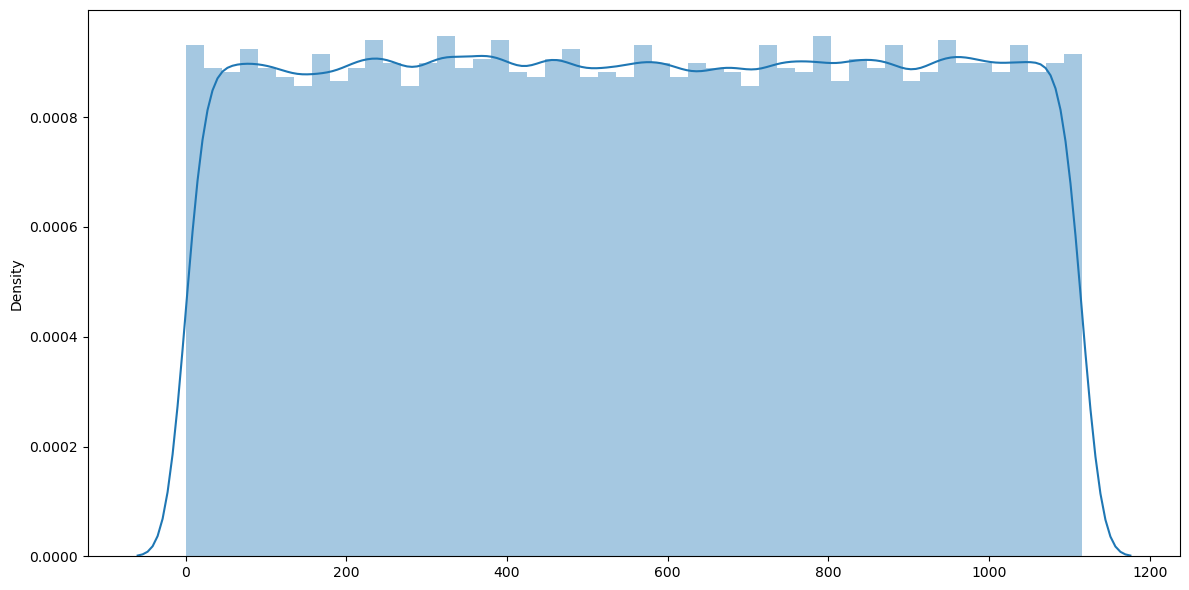

In [8]:
plt.figure(figsize=(12,6))
sns.distplot(x = train_df["Store"])
plt.tight_layout()

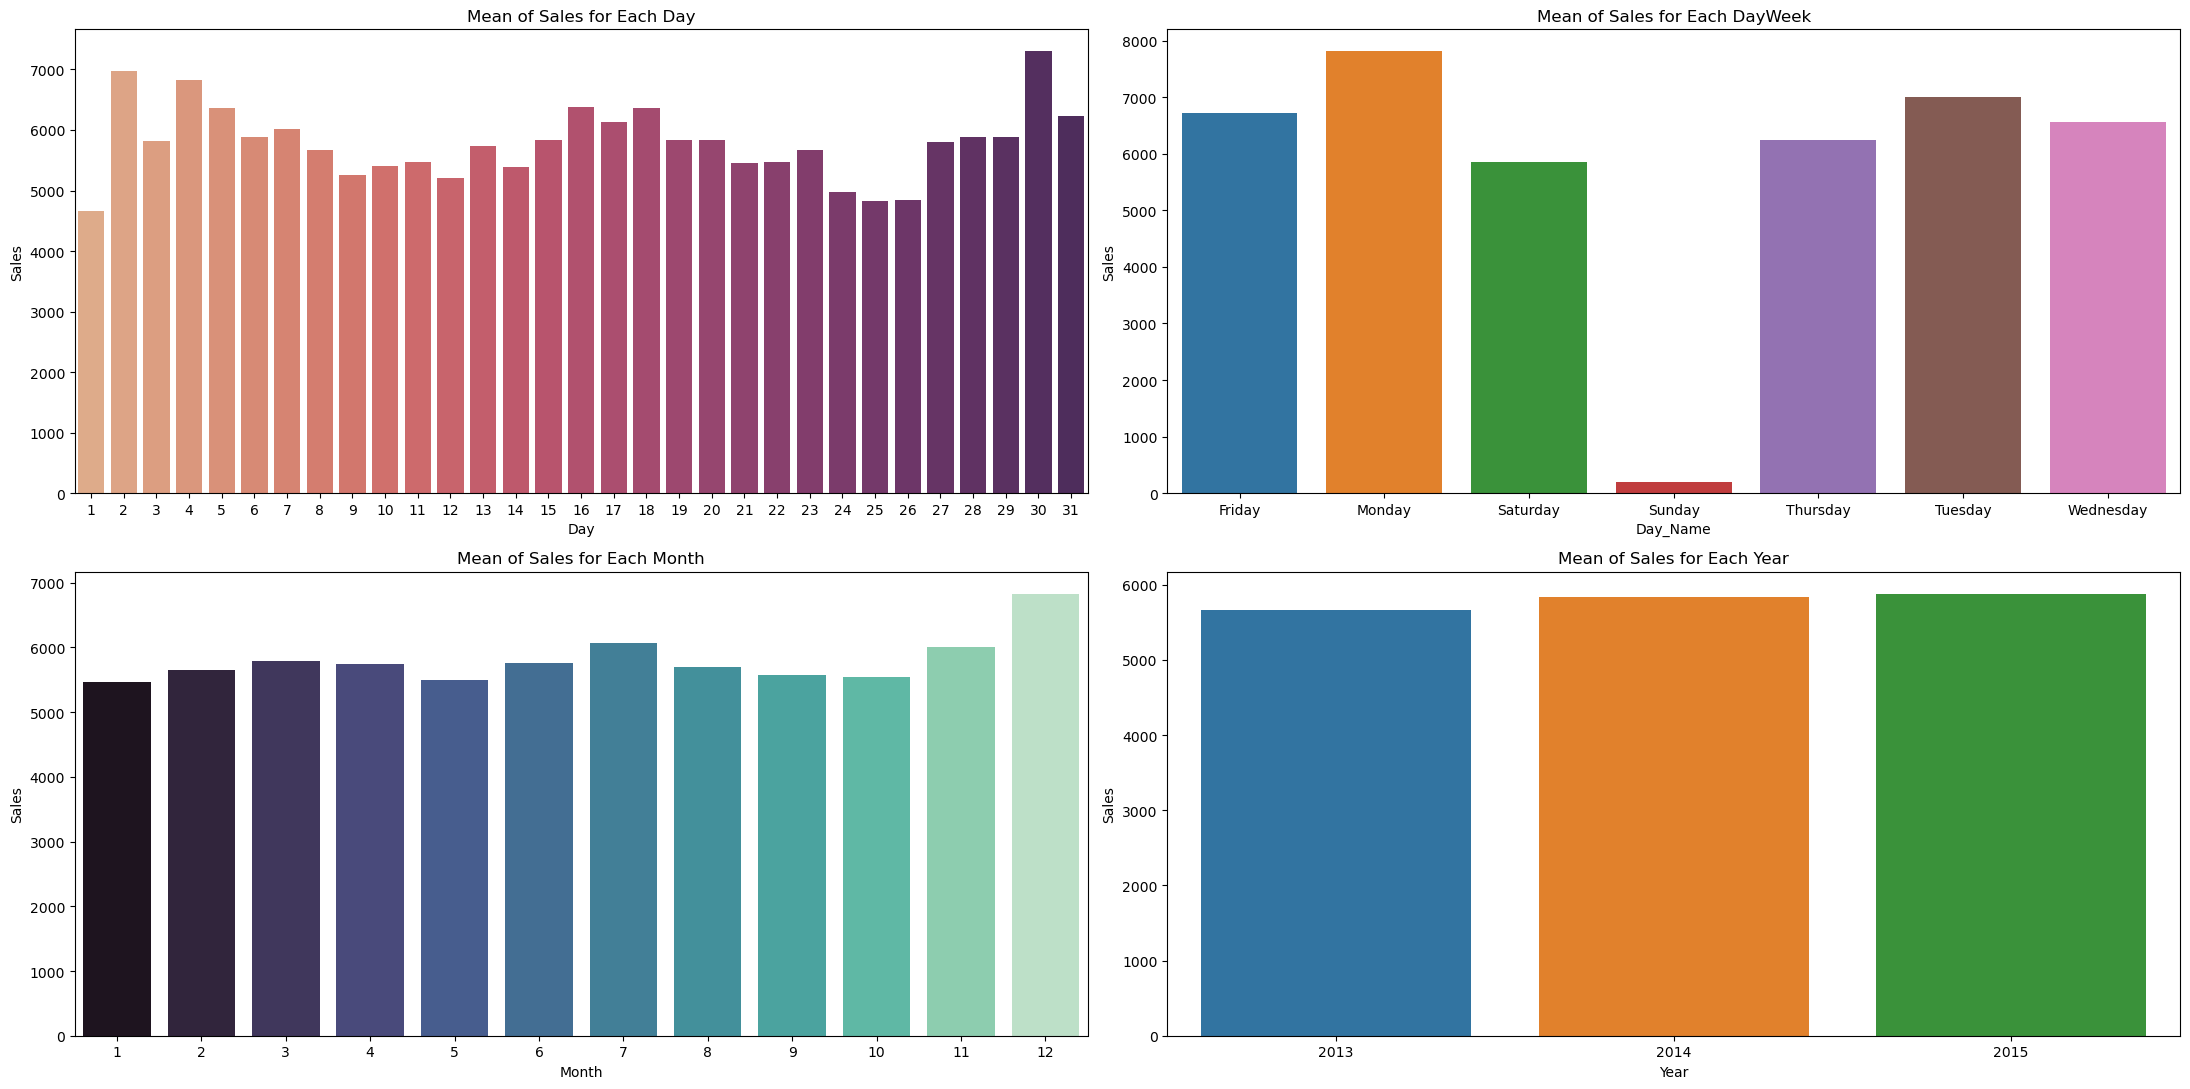

In [9]:
day_df = train_df.groupby("Day")["Sales"].mean().to_frame().reset_index()
day_name_df = train_df.groupby("Day_Name")["Sales"].mean().to_frame().reset_index()
month_df = train_df.groupby("Month")["Sales"].mean().to_frame().reset_index()
year_df = train_df.groupby("Year")["Sales"].mean().to_frame().reset_index()
fig , ax = plt.subplots(2,2,figsize = (22,11))
ax1 = sns.barplot(x=day_df["Day"],y=day_df["Sales"],ax=ax[0,0],palette="flare")
ax1.set_title("Mean of Sales for Each Day")
ax2 = sns.barplot(x=day_name_df["Day_Name"],y=day_name_df["Sales"],ax=ax[0,1])
ax2.set_title("Mean of Sales for Each DayWeek")
ax3 = sns.barplot(x=month_df["Month"],y=month_df["Sales"],ax=ax[1,0],palette="mako")
ax3.set_title("Mean of Sales for Each Month")
ax4 = sns.barplot(x=year_df["Year"],y=year_df["Sales"],ax=ax[1,1])
ax4.set_title("Mean of Sales for Each Year")
plt.tight_layout()

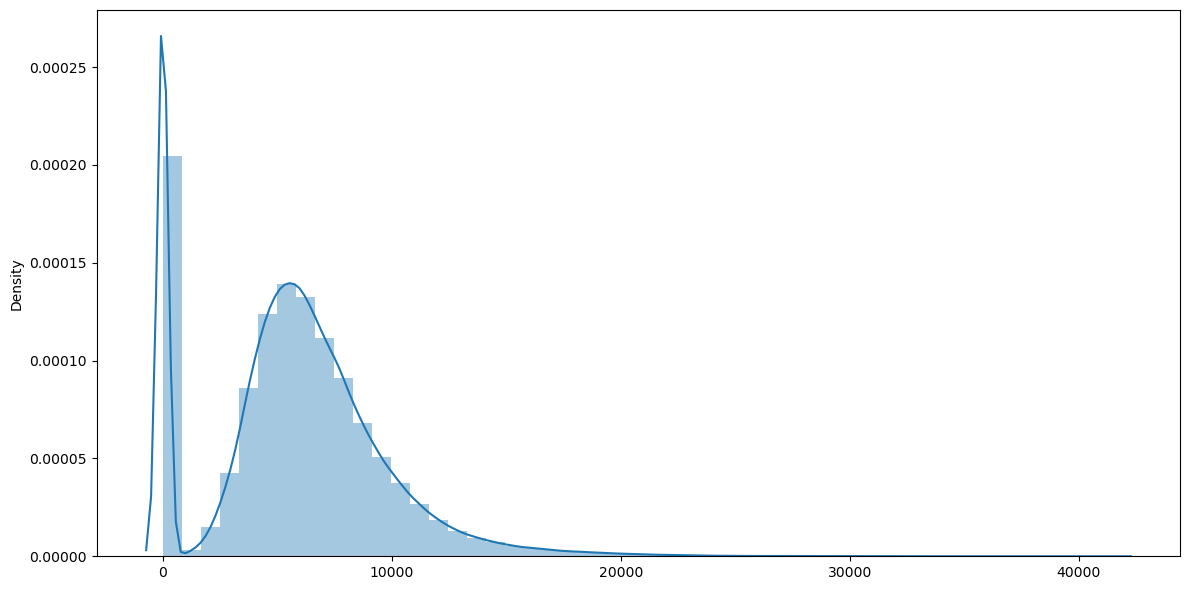

In [10]:
plt.figure(figsize=(12,6))
sns.distplot(x = train_df["Sales"])
plt.tight_layout()

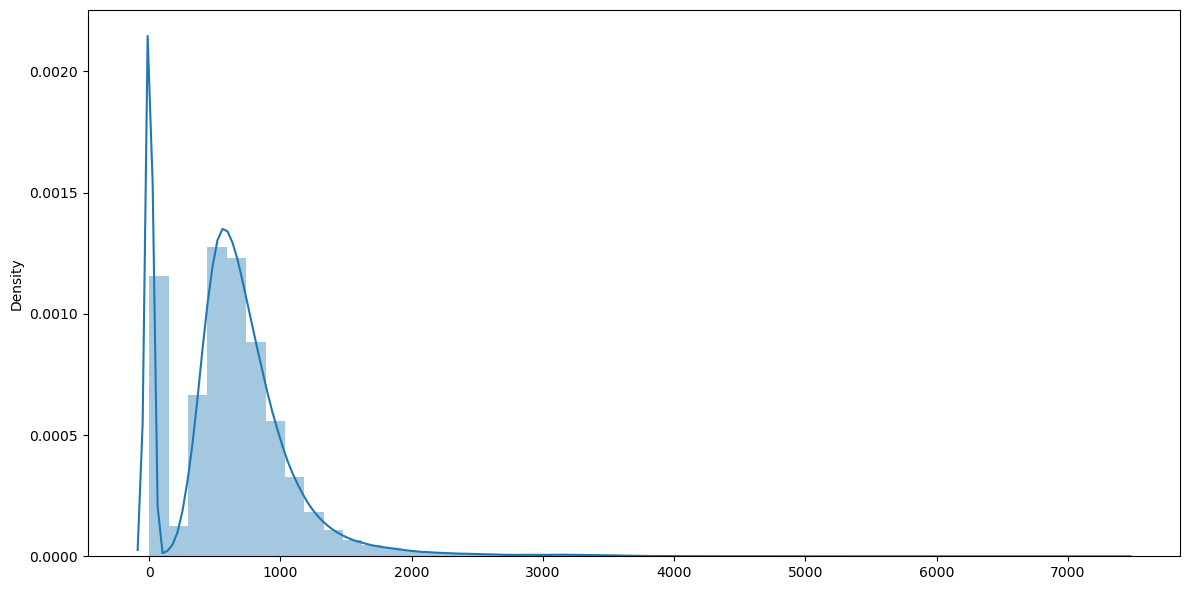

In [11]:
plt.figure(figsize=(12,6))
sns.distplot(x = train_df["Customers"])
plt.tight_layout()

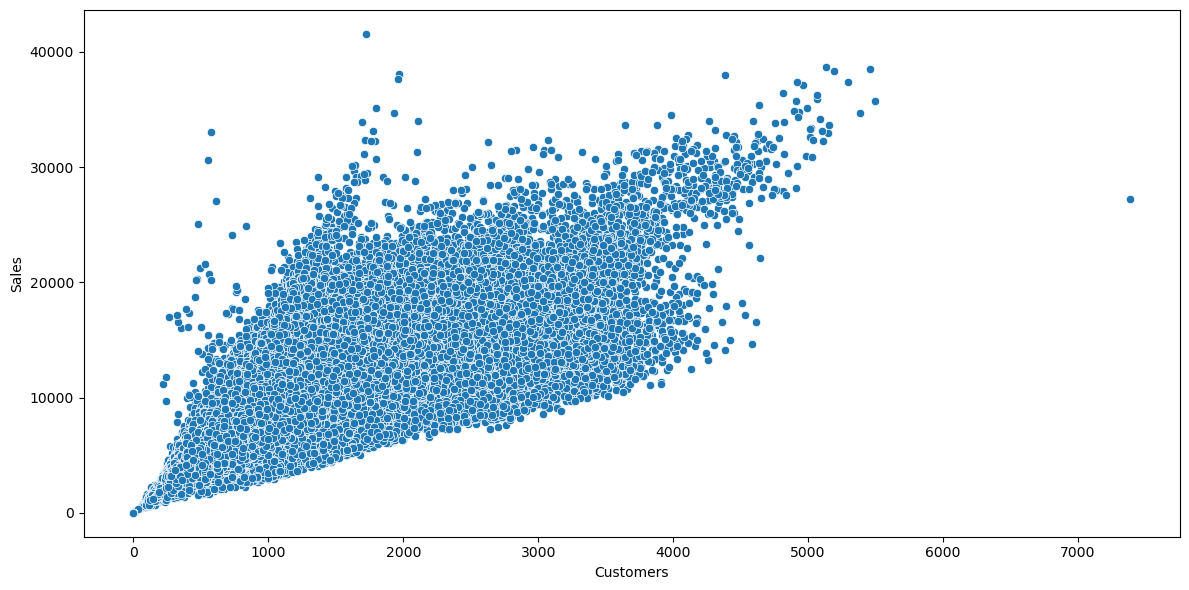

In [12]:
plt.figure(figsize=(12,6))
sns.scatterplot(x = train_df["Customers"],y=train_df["Sales"])
plt.tight_layout()

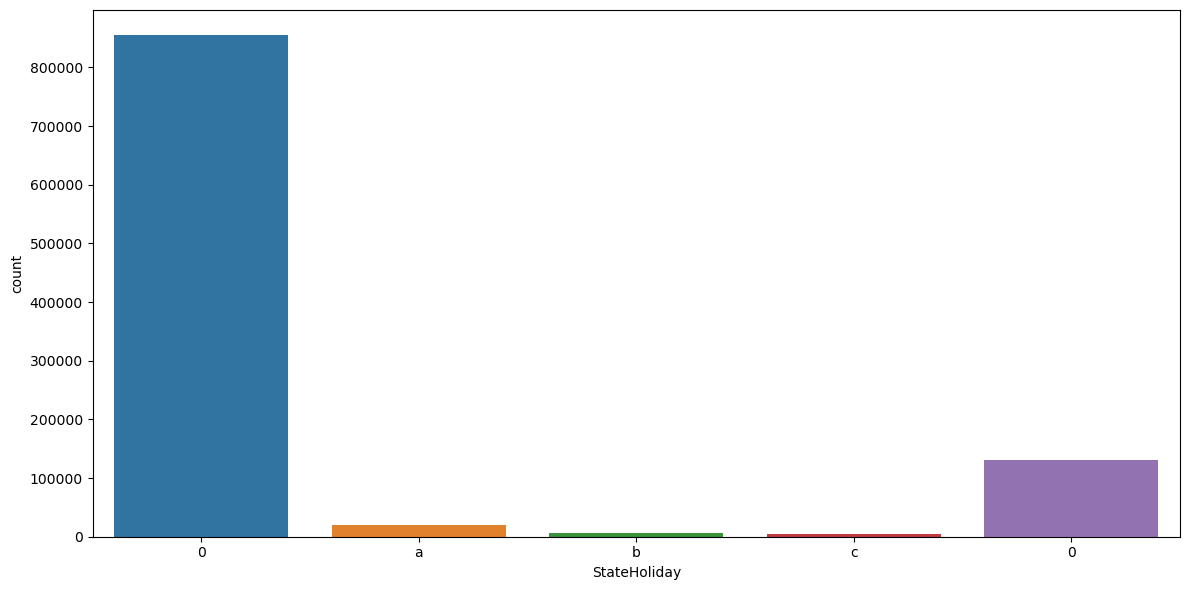

In [13]:
plt.figure(figsize=(12,6))
sns.countplot(x = train_df["StateHoliday"])
plt.tight_layout()

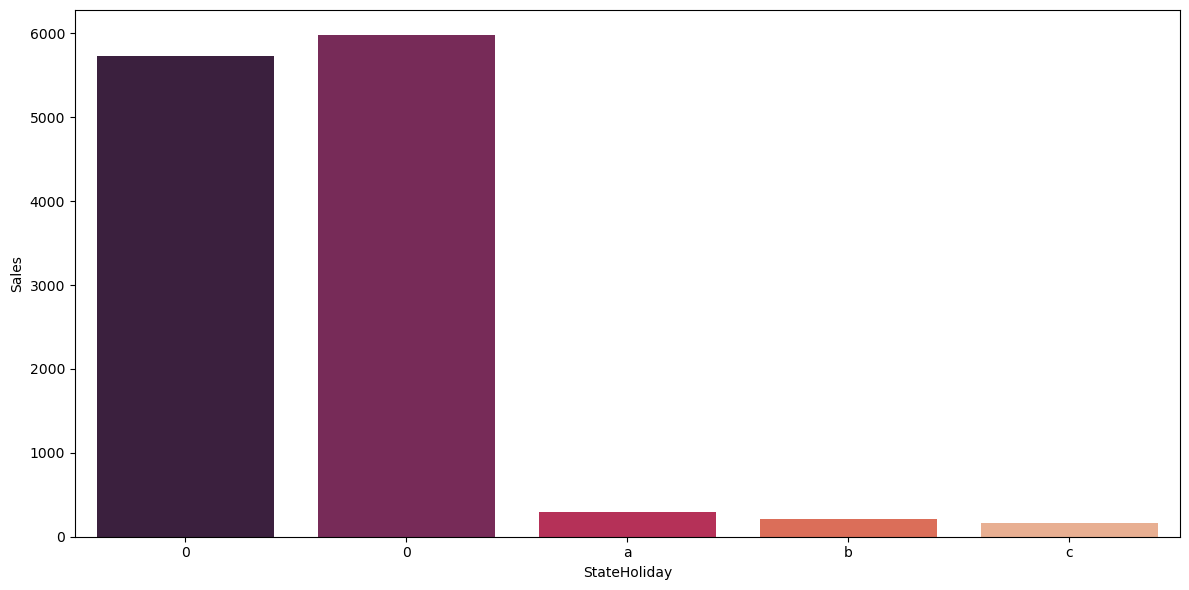

In [14]:
plt.figure(figsize=(12,6))
StateHoliday_df = train_df.groupby("StateHoliday")["Sales"].mean().to_frame().reset_index()
sns.barplot(x=StateHoliday_df["StateHoliday"],y=StateHoliday_df["Sales"],palette="rocket")
plt.tight_layout()

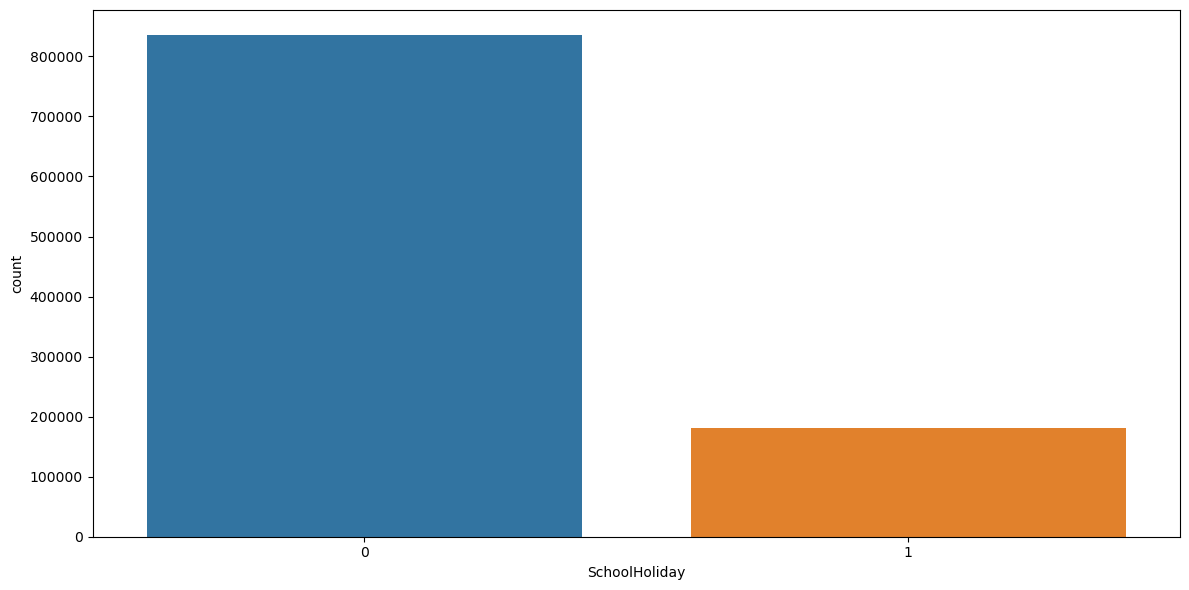

In [15]:
plt.figure(figsize=(12,6))
sns.countplot(x = train_df["SchoolHoliday"])
plt.tight_layout()

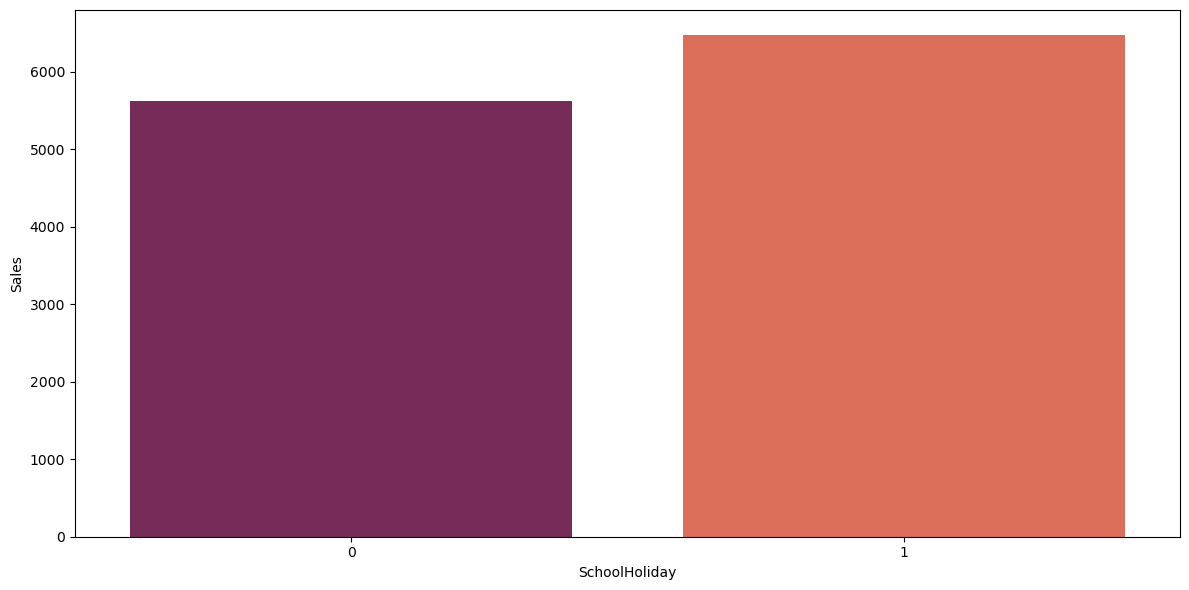

In [16]:
plt.figure(figsize=(12,6))
SchoolHoliday_df = train_df.groupby("SchoolHoliday")["Sales"].mean().to_frame().reset_index()
sns.barplot(x=SchoolHoliday_df["SchoolHoliday"],y=SchoolHoliday_df["Sales"],palette="rocket")
plt.tight_layout()

In [19]:
merged_df = train_df.merge(store_df, how='left', on='Store') #this is gonna be the merged training dataset
merged_test_df = test_df.merge(store_df, how='left', on='Store') #this is gonna be the merged testing dataset

<Axes: >

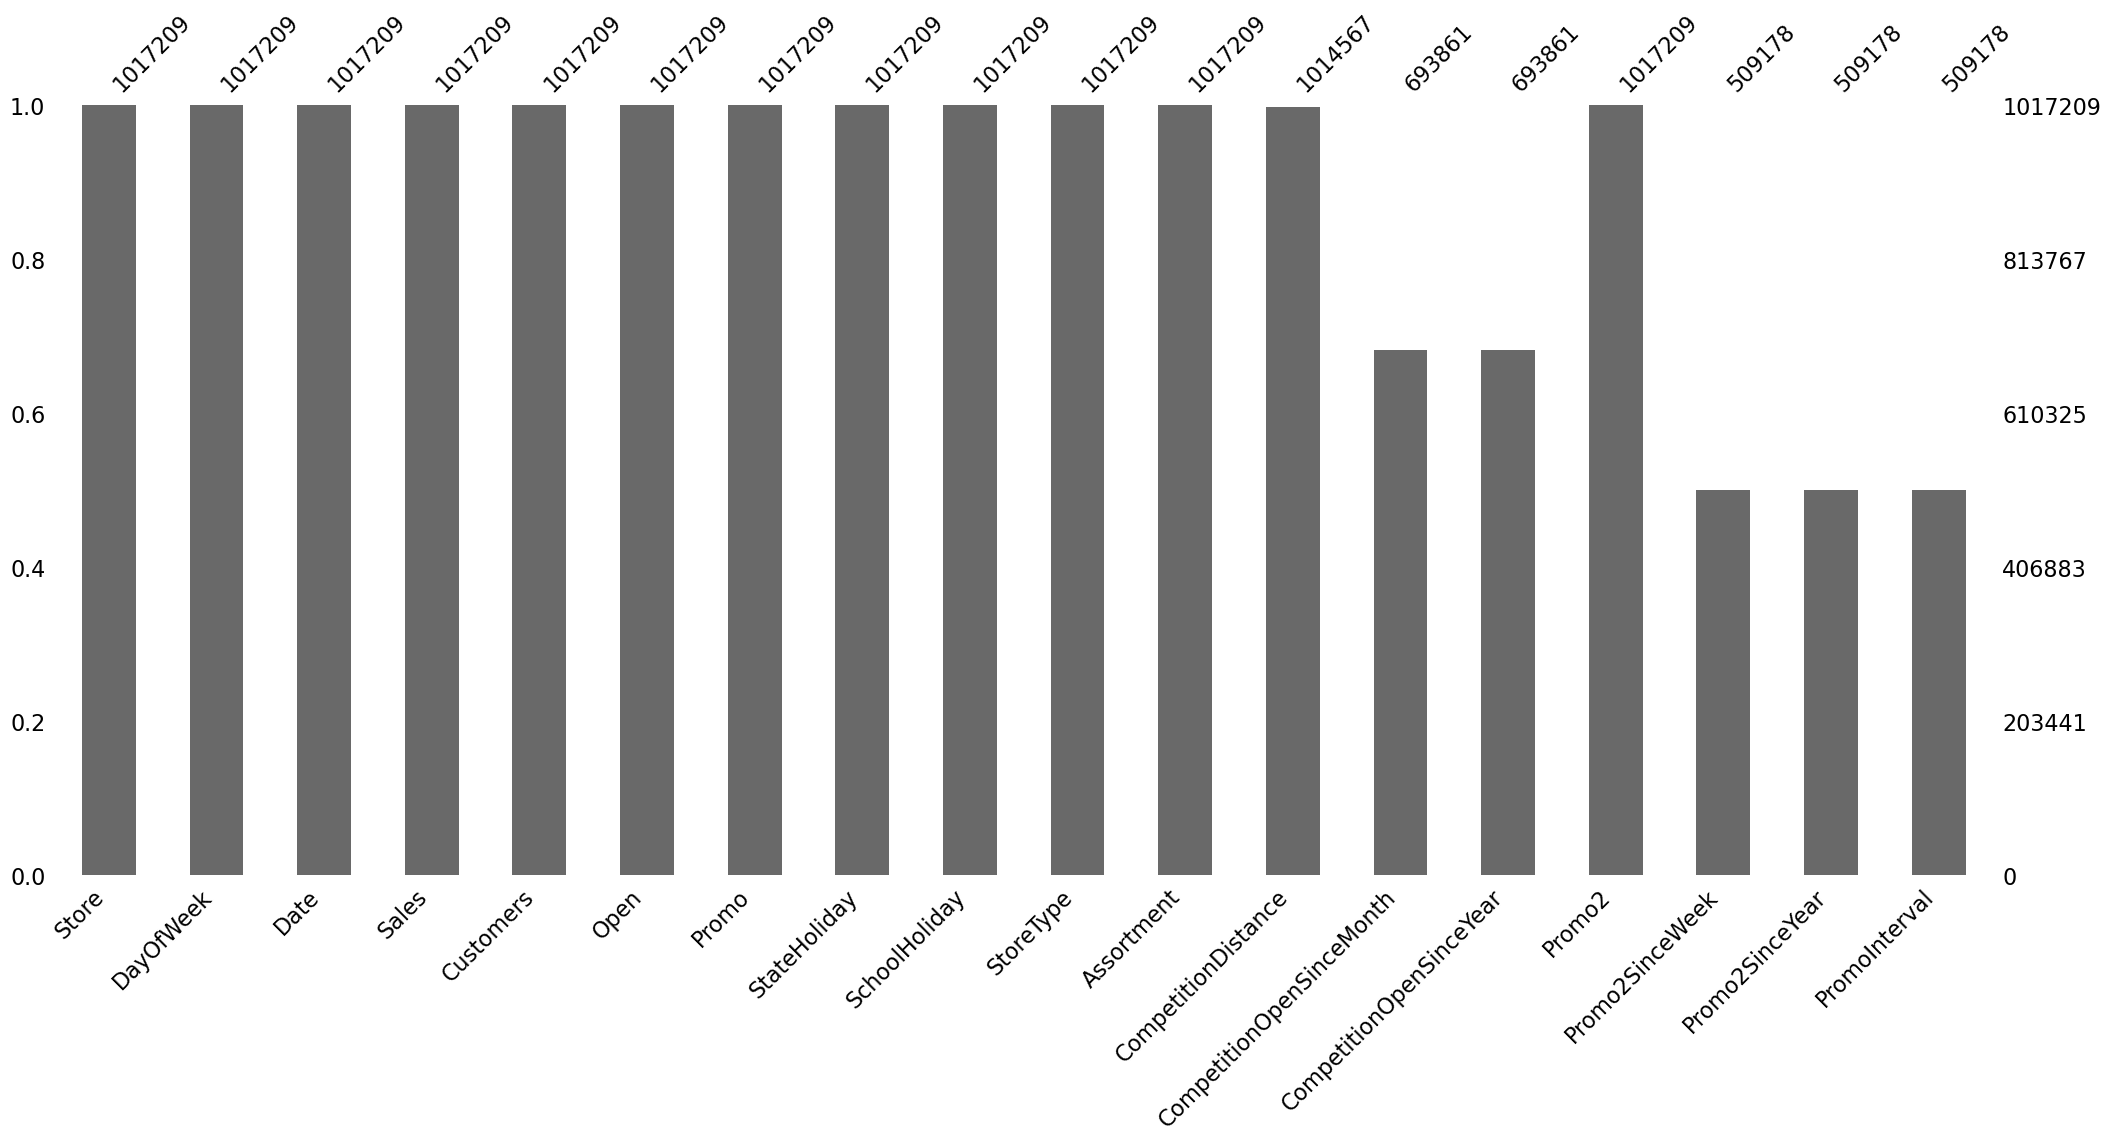

In [22]:
import missingno as msno

msno.bar(merged_df)

# Preprocessing and Feature Engineering

Let's take a look at the available columns, and figure out if we can create new columns or apply any useful transformations.

$Feature engineering$ is the process of transforming raw data into features that can be used by a machine learning model to make accurate predictions. It involves selecting, extracting, and transforming the most relevant information from the raw data to create a new set of features that captures the underlying patterns and relationships in the data.

Feature engineering is important because it can significantly improve the performance of a machine learning model. By creating new features that capture the most important aspects of the data, we can help the model identify the underlying patterns and relationships in the data more accurately. This, in turn, leads to better predictions and more reliable insights.

In [23]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 18 columns):
 #   Column                     Non-Null Count    Dtype  
---  ------                     --------------    -----  
 0   Store                      1017209 non-null  int64  
 1   DayOfWeek                  1017209 non-null  int64  
 2   Date                       1017209 non-null  object 
 3   Sales                      1017209 non-null  int64  
 4   Customers                  1017209 non-null  int64  
 5   Open                       1017209 non-null  int64  
 6   Promo                      1017209 non-null  int64  
 7   StateHoliday               1017209 non-null  object 
 8   SchoolHoliday              1017209 non-null  int64  
 9   StoreType                  1017209 non-null  object 
 10  Assortment                 1017209 non-null  object 
 11  CompetitionDistance        1014567 non-null  float64
 12  CompetitionOpenSinceMonth  693861 non-null   float64
 13  CompetitionO

## Date

**First, let's convert `Date` to a `datetime` column and extract different parts of the date. This will be very usefull case a ML model there is no use n having a `Date` in $object$ format. Thus extracting them into $year$, $month$, $day$, $week of the year$ and $day of the week$ will be very helpful for the model to understand any seasonality between these features and the rest of the columns.**

In [24]:
def split_date(df): #A helper function that takes a df and finds the Date column and extract the necessary info.
    df['Date'] = pd.to_datetime(df['Date'])
    df['Year'] = df.Date.dt.year
    df['Month'] = df.Date.dt.month
    df['Day'] = df.Date.dt.day
    df['WeekOfYear'] = df.Date.dt.isocalendar().week  #since we have day of the week already let's extrac the rest

In [25]:
split_date(merged_df)
split_date(merged_test_df)
merged_df

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month,Day,WeekOfYear
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN,2015,7,31,31
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct",2015,7,31,31
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",2015,7,31,31
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN,2015,7,31,31
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN,2015,7,31,31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017204,1111,2,2013-01-01,0,0,0,0,a,1,a,a,1900.0,6.0,2014.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct",2013,1,1,1
1017205,1112,2,2013-01-01,0,0,0,0,a,1,c,c,1880.0,4.0,2006.0,0,NaN,NaN,NaN,2013,1,1,1
1017206,1113,2,2013-01-01,0,0,0,0,a,1,a,c,9260.0,NaN,NaN,0,NaN,NaN,NaN,2013,1,1,1
1017207,1114,2,2013-01-01,0,0,0,0,a,1,a,c,870.0,NaN,NaN,0,NaN,NaN,NaN,2013,1,1,1


## Store Open/Closed

## [Important]

#### Next, notice that the sales are zero whenever the store is closed.

In [26]:
merged_df.groupby(by='Open')['Sales'].sum()

Open
0             0
1    5873180623
Name: Sales, dtype: int64

**As dicussed earlier Instead of trying to model this relationship, it would be better to hard-code it in our predictions, and remove the rows where the store is closed. We won't remove any rows from the test set, since we need to make predictions for every row. Later we'll mark zero for sales whereever the store is closed**

In [27]:
merged_df = merged_df[merged_df.Open == 1].copy() #Filtering only the rows where the store is open.
merged_df.groupby(by='Open')['Sales'].sum()

Open
1    5873180623
Name: Sales, dtype: int64

after filtering see there is no value as 'open==0'

## Competition

Next, we can use the columns `CompetitionOpenSince[Month/Year]` columns from `store_df` to compute the number of months for which a competitor has been open near the store. As having the values split into year and months we'll try having the total no. of time in months and see if it helps our model.


## Note:
Again this is just an idea it might help our model or may not help this can only been seen when we see our training and validation results.

In [28]:
"""
This code creates a new feature called 'CompetitionOpen' in the input DataFrame, 
which represents the number of months that the competition for a given store has been open.

The function takes as input a DataFrame with columns 'Year', 'Month', 'CompetitionOpenSinceYear', and 'CompetitionOpenSinceMonth'. 
It first calculates the difference in months between the current year/month and the year/month when the competition opened. 
If the difference is negative (i.e., the competition has not yet opened), the function sets the value of 'CompetitionOpen' to 0.
Finally, it fills any missing values in 'CompetitionOpen' with 0.
"""    

def comp_months(df):
    df['CompetitionOpen'] = 12 * (df.Year - df.CompetitionOpenSinceYear) + (df.Month - df.CompetitionOpenSinceMonth)
    df['CompetitionOpen'] = df['CompetitionOpen'].map(lambda x: 0 if x < 0 else x).fillna(0)

In [29]:
comp_months(merged_df)
comp_months(merged_test_df)

Let's view the results of the new columns we've created.

In [30]:
merged_df[['Date', 'CompetitionDistance', 'CompetitionOpenSinceYear', 'CompetitionOpenSinceMonth', 'CompetitionOpen']].sample(20)

,Date,CompetitionDistance,CompetitionOpenSinceYear,CompetitionOpenSinceMonth,CompetitionOpen
732342,2013-09-13,1190.0,2012.0,11.0,10.0
643320,2013-12-02,650.0,2006.0,10.0,86.0
312635,2014-10-11,NaN,NaN,NaN,0.0
836872,2013-06-11,140.0,2007.0,11.0,67.0
554920,2014-02-19,2300.0,NaN,NaN,0.0
300543,2014-10-24,830.0,NaN,NaN,0.0
625158,2013-12-18,16350.0,2005.0,7.0,101.0
105245,2015-04-28,2300.0,NaN,NaN,0.0
165014,2015-03-06,900.0,2010.0,9.0,54.0
766336,2013-08-13,570.0,2007.0,11.0,69.0


## Additional Promotion

We can also add some additional columns to indicate how long a store has been running `Promo2` and whether a new round of `Promo2` starts in the current month. This is another try to check wether this tranformation is helpful for our model.

## Note:
Again this is just an idea it might help our model or may not help this can only been seen when we see our training and validation results.

In [31]:
"""

`promo_cols()` function creates new features related to promotions. It calculates how long the promotional offer has been open (in months) and 
creates a new feature 'Promo2Open'. It also creates a new feature 'IsPromo2Month' to check whether a new round of promotions was started 
in the current month.

`check_promo_month(row)` is a helper function used by `promo_cols()` function to check whether a new round of promotions was started in the current month. 
It takes a row as an input and returns 1 if a new round of promotions was started in the current month, otherwise 0. 
It uses the 'PromoInterval' column to get the months when the promotions are active and checks whether the current month is in that list.

"""

# Code not important just understand what we are trying to find.


def check_promo_month(row):
    month2str = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun',              
                 7:'Jul', 8:'Aug', 9:'Sept', 10:'Oct', 11:'Nov', 12:'Dec'}
    try:
        months = (row['PromoInterval'] or '').split(',')
        if row['Promo2Open'] and month2str[row['Month']] in months:
            return 1
        else:
            return 0
    except Exception:
        return 0

def promo_cols(df):
    # Months since Promo2 was open
    df['Promo2Open'] = 12 * (df.Year - df.Promo2SinceYear) +  (df.WeekOfYear - df.Promo2SinceWeek)*7/30.5
    df['Promo2Open'] = df['Promo2Open'].map(lambda x: 0 if x < 0 else x).fillna(0) * df['Promo2']
    # Whether a new round of promotions was started in the current month
    df['IsPromo2Month'] = df.apply(check_promo_month, axis=1) * df['Promo2']

In [32]:
promo_cols(merged_df)
promo_cols(merged_test_df)

Let's view the results of the columns we've created.

In [33]:
merged_df[['Date', 'Promo2', 'Promo2SinceYear', 'Promo2SinceWeek', 'PromoInterval', 'Promo2Open', 'IsPromo2Month']].sample(20)

,Date,Promo2,Promo2SinceYear,Promo2SinceWeek,PromoInterval,Promo2Open,IsPromo2Month
936149,2013-03-14,1,2013.0,31.0,"Jan,Apr,Jul,Oct",0.000000,0
290893,2014-11-03,0,NaN,NaN,NaN,0.000000,0
278386,2014-11-17,0,NaN,NaN,NaN,0.000000,0
918848,2013-03-30,0,NaN,NaN,NaN,0.000000,0
795871,2013-07-18,1,2010.0,35.0,"Mar,Jun,Sept,Dec",34.622951,0
288028,2014-11-06,1,2011.0,14.0,"Jan,Apr,Jul,Oct",43.114754,0
937380,2013-03-13,1,2010.0,13.0,"Jan,Apr,Jul,Oct",35.540984,0
857304,2013-05-24,1,2013.0,5.0,"Feb,May,Aug,Nov",3.672131,1
561807,2014-02-13,1,2011.0,22.0,"Jan,Apr,Jul,Oct",32.557377,0
922799,2013-03-26,1,2009.0,45.0,"Feb,May,Aug,Nov",40.655738,0


The features related to competition and promotion are now much more useful.

# Preparing Input and Target Columns

Let's select the columns that we'll use for training. Since we modified several columsn through feature engineering we have to either delete the old columns or filter the dataset wih only necessay and modified columns. The later method is what i'm gonna use also it is pretty handy. Refer [HERE](https://www.kaggle.com/code/sridharstreaks/decision-trees-intution-model-building?scriptVersionId=127577600&cellId=35).

Below i'm using a method by which:

1. ***I'll create a list of column names extracted from my source dataset like `list(dataset_name.columns)` . This will create a list of column names I wish to extract.***
2. ***Now i can store this list in some value like `name_of_list`. Then i can use this stored list of column names to act like a filter on any dataset that contains similar column names. This is actually usefull that you don't have to modify the dataframe each time.***

In [34]:
merged_df.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval', 'Year', 'Month', 'Day',
       'WeekOfYear', 'CompetitionOpen', 'Promo2Open', 'IsPromo2Month'],
      dtype='object')

In [35]:
# Selecting only the required columns which i think will be good for ML model.

input_cols = ['Store', 'DayOfWeek', 'Promo', 'StateHoliday', 'SchoolHoliday', 
              'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpen', 
              'Day', 'Month', 'Year', 'WeekOfYear',  'Promo2', 
              'Promo2Open', 'IsPromo2Month']
target_col = 'Sales'

In [36]:
# This created a dataframe with only columns names from the list we created above.

inputs = merged_df[input_cols].copy()
targets = merged_df[target_col].copy()
inputs

,Store,DayOfWeek,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpen,Day,Month,Year,WeekOfYear,Promo2,Promo2Open,IsPromo2Month
0,1,5,1,0,1,c,a,1270.0,82.0,31,7,2015,31,0,0.000000,0
1,2,5,1,0,1,a,a,570.0,92.0,31,7,2015,31,1,64.131148,1
2,3,5,1,0,1,a,a,14130.0,103.0,31,7,2015,31,1,51.901639,1
3,4,5,1,0,1,c,c,620.0,70.0,31,7,2015,31,0,0.000000,0
4,5,5,1,0,1,a,a,29910.0,3.0,31,7,2015,31,0,0.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1016776,682,2,0,a,1,b,a,150.0,76.0,1,1,2013,1,0,0.000000,0
1016827,733,2,0,a,1,b,b,860.0,159.0,1,1,2013,1,0,0.000000,0
1016863,769,2,0,a,1,b,b,840.0,0.0,1,1,2013,1,1,1.213115,1
1017042,948,2,0,a,1,b,b,1430.0,0.0,1,1,2013,1,0,0.000000,0


In [37]:
# Similarly doing the same for the test dataset
test_inputs = merged_test_df[input_cols].copy()
test_inputs

,Store,DayOfWeek,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpen,Day,Month,Year,WeekOfYear,Promo2,Promo2Open,IsPromo2Month
0,1,4,1,0,0,c,a,1270.0,84.0,17,9,2015,38,0,0.000000,0
1,3,4,1,0,0,a,a,14130.0,105.0,17,9,2015,38,1,53.508197,0
2,7,4,1,0,0,a,c,24000.0,29.0,17,9,2015,38,0,0.000000,0
3,8,4,1,0,0,a,a,7520.0,11.0,17,9,2015,38,0,0.000000,0
4,9,4,1,0,0,a,c,2030.0,181.0,17,9,2015,38,0,0.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41083,1111,6,0,0,0,a,a,1900.0,14.0,1,8,2015,31,1,24.000000,0
41084,1112,6,0,0,0,c,c,1880.0,112.0,1,8,2015,31,0,0.000000,0
41085,1113,6,0,0,0,a,c,9260.0,0.0,1,8,2015,31,0,0.000000,0
41086,1114,6,0,0,0,a,c,870.0,0.0,1,8,2015,31,0,0.000000,0


Let's also identify numeric and categorical columns. We can use a automatically select numerical columns using `dtypes` like [THIS](https://www.kaggle.com/code/sridharstreaks/decision-trees-intution-model-building?scriptVersionId=127577600&cellId=41) else we can choose manually like below. 

## **Note: that we can treat binary categorical columns (0/1) as numeric columns.**

**As of now there is no major difference in treating the columns like `SchoolHoliday` , `Promo` etc as numerical even those they are categorical solumn with numbers. If the perfomance of the model gets affected then we can try treating these as categorical columns**

For this tutorial the below are my selected **numerical** and **categorical** columns.

In [38]:
numeric_cols = ['Store', 'Promo', 'SchoolHoliday', 
              'CompetitionDistance', 'CompetitionOpen', 'Promo2', 'Promo2Open', 'IsPromo2Month',
              'Day', 'Month', 'Year', 'WeekOfYear',  ]
categorical_cols = ['DayOfWeek', 'StateHoliday', 'StoreType', 'Assortment']

# Impute missing numerical data

Imputing missing data is the process of filling in missing values in a dataset with estimated values. Missing data can arise due to a variety of reasons such as data entry errors, sensor malfunction, or simply the lack of information. Missing data can be problematic as it can lead to biased or inefficient analysis, and sometimes make the data unusable altogether.

There are several methods for imputing missing data, including mean imputation, mode imputation, regression imputation, and multiple imputation. Mean imputation involves replacing missing values with the mean value of the non-missing values for that variable. Mode imputation is similar, but replaces missing values with the most common value for that variable. Regression imputation involves using a regression model to predict the missing values based on other variables in the dataset. Multiple imputation involves creating multiple imputed datasets and combining the results to create a final dataset.

The choice of imputation method depends on the nature of the missing data and the goals of the analysis. Regardless of the method used, it is important to carefully consider the potential impact of imputing missing data on the results of the analysis and to report any imputation methods used in the final analysis.

let's first check the amount of missing data in out `train` and `test` dataset

In [39]:
inputs[numeric_cols]

,Store,Promo,SchoolHoliday,CompetitionDistance,CompetitionOpen,Promo2,Promo2Open,IsPromo2Month,Day,Month,Year,WeekOfYear
0,1,1,1,1270.0,82.0,0,0.000000,0,31,7,2015,31
1,2,1,1,570.0,92.0,1,64.131148,1,31,7,2015,31
2,3,1,1,14130.0,103.0,1,51.901639,1,31,7,2015,31
3,4,1,1,620.0,70.0,0,0.000000,0,31,7,2015,31
4,5,1,1,29910.0,3.0,0,0.000000,0,31,7,2015,31
...,...,...,...,...,...,...,...,...,...,...,...,...
1016776,682,0,1,150.0,76.0,0,0.000000,0,1,1,2013,1
1016827,733,0,1,860.0,159.0,0,0.000000,0,1,1,2013,1
1016863,769,0,1,840.0,0.0,1,1.213115,1,1,1,2013,1
1017042,948,0,1,1430.0,0.0,0,0.000000,0,1,1,2013,1


In [40]:
inputs[numeric_cols].isna().sum()

Store                     0
Promo                     0
SchoolHoliday             0
CompetitionDistance    2186
CompetitionOpen           0
Promo2                    0
Promo2Open                0
IsPromo2Month             0
Day                       0
Month                     0
Year                      0
WeekOfYear                0
dtype: int64

In [41]:
test_inputs[numeric_cols].isna().sum()

Store                   0
Promo                   0
SchoolHoliday           0
CompetitionDistance    96
CompetitionOpen         0
Promo2                  0
Promo2Open              0
IsPromo2Month           0
Day                     0
Month                   0
Year                    0
WeekOfYear              0
dtype: int64

***Seems like competition distance is the only missing value, and we can simply fill it with the 2Xhighest value (to indicate that competition is very far away). This is only a assumption of mine you are welcome to use any `imputing methods` or delete those rows.But we can't delete the rows here as the summision csv requires all the rows from the `test` set. so, the next best idea is to make them negligible to have very less or no impact on our model.***

## Note: 
This is again an assumtion to see if this idea works in the favour of the model and yields good results. if not we have to change this assumption and come up with sommething else.

In [42]:
max_distance = inputs.CompetitionDistance.max()
max_distance

75860.0

In [43]:
inputs['CompetitionDistance'].fillna(max_distance*2, inplace=True) #Filling with 2X Highest value to indicate that the competition is non existent
test_inputs['CompetitionDistance'].fillna(max_distance*2, inplace=True)

checking the missing values after filling the missing 'CompetitionDistance' values

In [44]:
inputs[numeric_cols].isna().sum()

Store                  0
Promo                  0
SchoolHoliday          0
CompetitionDistance    0
CompetitionOpen        0
Promo2                 0
Promo2Open             0
IsPromo2Month          0
Day                    0
Month                  0
Year                   0
WeekOfYear             0
dtype: int64

In [45]:
test_inputs[numeric_cols].isna().sum()

Store                  0
Promo                  0
SchoolHoliday          0
CompetitionDistance    0
CompetitionOpen        0
Promo2                 0
Promo2Open             0
IsPromo2Month          0
Day                    0
Month                  0
Year                   0
WeekOfYear             0
dtype: int64

# Scale Numeric Values

In machine learning, scaling numerical features is the process of transforming numerical data so that it falls within a specific range. This is important because it can help improve the performance of certain machine learning algorithms. Some of the most commonly used scaling techniques are min-max scaling, mean normalization, and standardization.

Scaling numerical features is important because many machine learning algorithms work better when the features are on a similar scale. This is because algorithms like linear regression and K-nearest neighbors use distance measures to compare features, and when the features are on vastly different scales, this can cause problems. Additionally, scaling can help to speed up the convergence of some optimization algorithms used in machine learning.

Another reason why scaling numerical features is important is that some features may have very different variances or ranges, which can cause them to dominate the objective function of the machine learning algorithm. This can lead to biased results, where certain features have a much larger influence on the outcome than others. By scaling the features, we can avoid this problem.

There are several methods by which we can scale the numerical features and it also depends on various factors like type of data we have, do we have outliers, do we wanna scale including negative scales etc. I'll link a article to know more about which scaler to use when [HERE](https://towardsdatascience.com/feature-scaling-effect-of-different-scikit-learn-scalers-deep-dive-8dec775d4946).

Here i'm gonna use `StandardScaler` which is quite reliable in many situations. You can view my other methods [Quantiletransformer](https://www.kaggle.com/code/sridharstreaks/decision-trees-intution-model-building?scriptVersionId=127577600&cellId=53). Before that we can view how our data is distributed before scaling using the describe function.

In [46]:
inputs[numeric_cols].describe().loc[['min','max']]

,Store,Promo,SchoolHoliday,CompetitionDistance,CompetitionOpen,Promo2,Promo2Open,IsPromo2Month,Day,Month,Year,WeekOfYear
min,1.0,0.0,0.0,20.0,0.0,0.0,0.0,0.0,1.0,1.0,2013.0,1.0
max,1115.0,1.0,1.0,151720.0,1386.0,1.0,72.0,1.0,31.0,12.0,2015.0,52.0


In [47]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(inputs[numeric_cols])

In [48]:
inputs[numeric_cols] = scaler.transform(inputs[numeric_cols])
test_inputs[numeric_cols] = scaler.transform(test_inputs[numeric_cols])

In [49]:
inputs[numeric_cols].describe().loc[['min','max']]

,Store,Promo,SchoolHoliday,CompetitionDistance,CompetitionOpen,Promo2,Promo2Open,IsPromo2Month,Day,Month,Year,WeekOfYear
min,-1.732571,-0.897887,-0.489947,-0.539902,-0.643561,-0.997372,-0.686969,-0.418274,-1.708501,-1.457834,-1.070346,-1.573812
max,1.729942,1.113726,2.041038,13.540960,20.617466,1.002635,3.105031,2.390776,1.746347,1.851502,1.502796,1.970371


This is after we scale the data. As we can see the data is nicely scalled between the range $(-1,1)$ according to each feature weightage. First we'll use this scaler's scaled values into our model. Then if this isn't satisfactory then we'll try to incoporate other scalers.

# Encode Categorical Columns

In machine learning, encoding categorical features refers to the process of transforming non-numerical data into numerical data. This is important because most machine learning algorithms are designed to work with numerical data, and as such, non-numerical data needs to be transformed before it can be used to train these models.

Categorical variables are variables that represent categories or groups, such as gender (male/female), education level (high school/bachelor's degree/master's degree), or geographic region (North/South/East/West). There are different ways to encode categorical variables, including one-hot encoding, label encoding, and binary encoding.

One-hot encoding involves creating a new binary column for each unique category in a categorical variable. Label encoding involves assigning a unique integer to each unique category in a categorical variable. Binary encoding is similar to one-hot encoding, but instead of creating a new column for each unique category, it creates a new column for each bit in the binary representation of the unique integer assigned to each category.

The choice of encoding method depends on the type of data and the specific machine learning algorithm being used. The importance of encoding categorical features lies in the fact that they can be a valuable source of information in a dataset, but need to be transformed into numerical data for machine learning algorithms to be able to use them effectively. By encoding categorical features, we can capture the information they contain and improve the accuracy of our machine learning models.

you can learn more about One-Hot Encoder and it's parameters [HERE](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)

<img src="https://i.imgur.com/n8GuiOO.png" width="640">

Let's one-hot encode categorical columns.

In [57]:
inputs[categorical_cols]

,DayOfWeek,StateHoliday,StoreType,Assortment
0,5,0,c,a
1,5,0,a,a
2,5,0,a,a
3,5,0,c,c
4,5,0,a,a
...,...,...,...,...
1016776,2,a,b,a
1016827,2,a,b,b
1016863,2,a,b,b
1017042,2,a,b,b


In [58]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore').fit(inputs[categorical_cols].astype(str)) #This will handle unknown categories as separate one while Encoding values

In [59]:
encoded_cols = list(encoder.get_feature_names_out(categorical_cols).astype(str))
encoded_cols

['DayOfWeek_1',
 'DayOfWeek_2',
 'DayOfWeek_3',
 'DayOfWeek_4',
 'DayOfWeek_5',
 'DayOfWeek_6',
 'DayOfWeek_7',
 'StateHoliday_0',
 'StateHoliday_a',
 'StateHoliday_b',
 'StateHoliday_c',
 'StoreType_a',
 'StoreType_b',
 'StoreType_c',
 'StoreType_d',
 'Assortment_a',
 'Assortment_b',
 'Assortment_c']

These are the columns that are result of encoding.

In [61]:
inputs[encoded_cols] = encoder.transform(inputs[categorical_cols].astype(str)) #merging the encoded columns onto out inputs dataset
test_inputs[encoded_cols] = encoder.transform(test_inputs[categorical_cols].astype(str))
inputs[encoded_cols]

,DayOfWeek_1,DayOfWeek_2,DayOfWeek_3,DayOfWeek_4,DayOfWeek_5,DayOfWeek_6,DayOfWeek_7,StateHoliday_0,StateHoliday_a,StateHoliday_b,StateHoliday_c,StoreType_a,StoreType_b,StoreType_c,StoreType_d,Assortment_a,Assortment_b,Assortment_c
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1016776,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1016827,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1016863,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1017042,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


Finally, let's extract out all the numeric columns and encoded columns for training.

In [62]:
# Since i was using a list of columns instead of modifying the actual data i can simply combine the ist to create new ones and use as a new filter list.

X = inputs[numeric_cols + encoded_cols]
X_test = test_inputs[numeric_cols + encoded_cols]

X

,Store,Promo,SchoolHoliday,CompetitionDistance,CompetitionOpen,Promo2,Promo2Open,IsPromo2Month,Day,Month,Year,WeekOfYear,DayOfWeek_1,DayOfWeek_2,DayOfWeek_3,DayOfWeek_4,DayOfWeek_5,DayOfWeek_6,DayOfWeek_7,StateHoliday_0,StateHoliday_a,StateHoliday_b,StateHoliday_c,StoreType_a,StoreType_b,StoreType_c,StoreType_d,Assortment_a,Assortment_b,Assortment_c
0,-1.732571,1.113726,2.041038,-0.423877,0.614306,-0.997372,-0.686969,-0.418274,1.746347,0.347258,1.502796,0.511002,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
1,-1.729462,1.113726,2.041038,-0.488851,0.767705,1.002635,2.690605,2.390776,1.746347,0.347258,1.502796,0.511002,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
2,-1.726354,1.113726,2.041038,0.769794,0.936443,1.002635,2.046518,2.390776,1.746347,0.347258,1.502796,0.511002,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
3,-1.723246,1.113726,2.041038,-0.484210,0.430228,-0.997372,-0.686969,-0.418274,1.746347,0.347258,1.502796,0.511002,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,-1.720138,1.113726,2.041038,2.234501,-0.597541,-0.997372,-0.686969,-0.418274,1.746347,0.347258,1.502796,0.511002,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1016776,0.384100,-0.897887,2.041038,-0.527835,0.522267,-0.997372,-0.686969,-0.418274,-1.708501,-1.457834,-1.070346,-1.573812,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1016827,0.542617,-0.897887,2.041038,-0.461933,1.795475,-0.997372,-0.686969,-0.418274,-1.708501,-1.457834,-1.070346,-1.573812,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1016863,0.654511,-0.897887,2.041038,-0.463789,-0.643561,1.002635,-0.623078,2.390776,-1.708501,-1.457834,-1.070346,-1.573812,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1017042,1.210876,-0.897887,2.041038,-0.409025,-0.643561,-0.997372,-0.686969,-0.418274,-1.708501,-1.457834,-1.070346,-1.573812,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


# Gradient Boosting

We're now ready to train our gradient boosting machine (GBM) model. Here's how a GBM model works:

1. The average value of the target column and uses as an initial prediction every input.
2. The residuals (difference) of the predictions with the targets are computed.
3. A decision tree of limited depth is trained to **predict just the residuals** for each input.
4. Predictions from the decision tree are scaled using a parameter called the learning rate (this prevents overfitting)
5. Scaled predictions fro the tree are added to the previous predictions to obtain the new and improved predictions.
6. Steps 2 to 5 are repeated to create new decision trees, each of which is trained to predict just the residuals from the previous prediction.

The term "gradient" refers to the fact that each decision tree is trained with the purpose of reducing the loss from the previous iteration (similar to gradient descent). The term "boosting" refers the general technique of training new models to improve the results of an existing model. 

Gradient boosting is a popular machine learning algorithm used for both regression and classification tasks. It is an ensemble method that combines the predictions of several weak decision trees to form a more accurate prediction. Gradient boosting works by fitting the weak decision trees on the residuals of the previous decision trees. This way, the model learns to correct the errors of the previous model and makes more accurate predictions.

Some advantages of gradient boosting are:

1. High accuracy: Gradient boosting is known for its high accuracy in predicting outcomes, making it an ideal choice for many machine learning problems.

2. Robustness to outliers: Gradient boosting is less sensitive to outliers as it uses decision trees which can handle missing and inconsistent data.

3. Feature importance: Gradient boosting can be used to identify the most important features in a dataset, which is useful for feature selection and reducing dimensionality.

4. Flexibility: Gradient boosting can be used for both regression and classification problems, and can handle different types of data such as numerical, categorical, and text data.

5. Scalability: Gradient boosting can be easily parallelized and scaled up to handle large datasets.

6. Regularization: Gradient boosting includes regularization techniques such as early stopping and shrinkage, which help prevent overfitting and improve model performance.

For a mathematical explanation of gradient boosting, check out the following resources:

- [XGBoost Documentation](https://xgboost.readthedocs.io/en/latest/tutorials/model.html)
- [Video Tutorials on StatQuest](https://www.youtube.com/watch?v=3CC4N4z3GJc&list=PLblh5JKOoLUJjeXUvUE0maghNuY2_5fY6)

Here's a visual representation of gradient boosting:

![](https://miro.medium.com/max/560/1*85QHtH-49U7ozPpmA5cAaw.png)



### Training

To train a GBM, we can use the `XGBRegressor` class from the [`XGBoost`](https://xgboost.readthedocs.io/en/latest/) library. Also the parameters are similar to that of the random forests and decision trees. you can look at them [HERE](https://www.kaggle.com/code/sridharstreaks/decision-trees-intution-model-building?scriptVersionId=127577600&cellId=70) and [HERE](https://www.kaggle.com/code/sridharstreaks/random-forests-intuition-model-building?scriptVersionId=128019113&cellId=71). 

In [65]:
from xgboost import XGBRegressor

model = XGBRegressor(random_state=42, n_jobs=-1, n_estimators=20, max_depth=4) #for demonstration i'll be using very less estimators

Let's train the model using `model.fit`.

In [66]:
%%time

model.fit(X, targets)

CPU times: user 15.7 s, sys: 4.02 s, total: 19.7 s
Wall time: 1.96 s


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=20, n_jobs=-1, num_parallel_tree=None, predictor=None,
             random_state=42, ...)

`XGBoost` is similar to that of `Random Forests` but it also have its differences. Read few of them below. Also see my documentation on `Random Forests` [HERE](https://www.kaggle.com/code/sridharstreaks/random-forests-intuition-model-building).

In RF, each decision tree is built independently by randomly selecting a subset of features and training the tree on a bootstrapped sample of the dataset. The final prediction is then obtained by averaging the predictions of all the trees in the ensemble.

In contrast, XGBoost builds decision trees sequentially, where each new tree tries to correct the mistakes of the previous trees. The algorithm starts with a single decision tree, and in each subsequent iteration, it adds a new tree to the ensemble that tries to minimize the residual errors of the previous trees. The final prediction is obtained by summing the predictions of all the trees in the ensemble.

XGBoost has several advantages over RF and decision trees:

1. Regularization: XGBoost has built-in regularization techniques such as L1 and L2 regularization to prevent overfitting.

2. Scalability: XGBoost is highly scalable and can handle large datasets with millions of examples and features.

3. Speed: XGBoost is optimized for speed and can train models faster than RF and other gradient boosting algorithms.

4. Performance: XGBoost has been shown to outperform other machine learning algorithms on a wide range of tasks, including regression, classification, and ranking.

# Prediction

We can now make predictions and evaluate the model using `model.predict`.

In [67]:
preds = model.predict(X)
preds

array([ 8127.9404,  7606.919 ,  8525.857 , ...,  6412.8247,  9460.068 ,
       10302.145 ], dtype=float32)

The array u see above is the predicted values for sales of `X` i.e train dataset. This prediction would be usualy done on `test` dataset and check with `test targets` but sine we dont have that `test targets` we are predicting on train dataset and compare the results with our `targets` i.e train targets to get our model's accuracy.

# Evaluation

Let's evaluate the predictions using RMSE error.

The root mean squared error (RMSE) is a commonly used evaluation metric for regression models in machine learning. It is the square root of the average of the squared differences between the predicted and actual values of the target variable. In the context of XGBoost regression models, RMSE is used to measure the difference between the predicted and actual values of the target variable (i.e., the sales) in the Rossman Store Sales dataset.

The intuition behind using RMSE is to penalize the model more for larger errors, as the squared term amplifies larger differences between predicted and actual values. This means that RMSE is a more sensitive metric than other measures such as mean absolute error (MAE), which treats all errors as equally important.

XGBoost is different from random forest and decision trees because it uses gradient boosting, which is a technique that trains many weak learners (i.e., decision trees) in sequence to build a strong model. This allows XGBoost to be more powerful and flexible than random forests and decision trees, as it can learn complex, non-linear relationships in the data. Additionally, XGBoost includes regularization techniques to prevent overfitting and improve generalization performance, which can be a challenge for decision trees and random forests.

Read more about [HERE](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html).

In [68]:
from sklearn.metrics import mean_squared_error

# just creating a helper function as we'll using this rmse to evaluate multiple models and paramaters futher down.
# Thus instead of writing this code again and again i'm creating this simple function.
def rmse(a, b):
    return mean_squared_error(a, b, squared=False)

In [69]:
rmse(preds, targets)

2377.752008804669

This `2377.75` denotes that the results on average off by **2377 Dollars** in Sales. This is way off and it'll do even worse in predicts Sales for the `test` dataset we have. We have to reduce this gap and improve this accuracy. There are several methods to do this. we'll explore some of them below.

# Visualization

We can visualize individual trees using `plot_tree` (note: this requires the `graphviz` library to be installed). This allows us to what this model is doing with the data and how it is coming up the predictions.

In [72]:
from xgboost import plot_tree

ExecutableNotFound: failed to execute PosixPath('dot'), make sure the Graphviz executables are on your systems' PATH

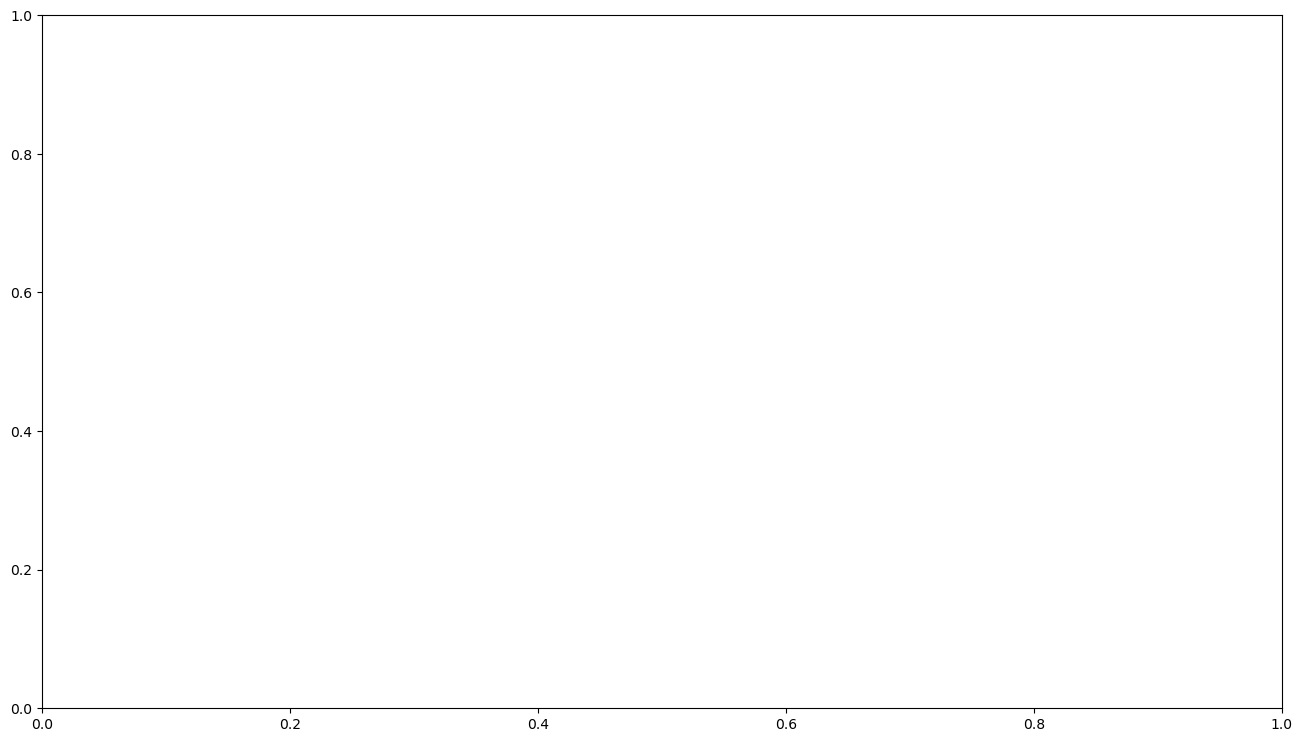

In [76]:
fig, ax = plt.subplots(figsize=(16, 9))
plot_tree(model, rankdir='LR',ax=ax)
plt.show();

The code `plot_tree(model, rankdir='LR')` generates a visual representation of the decision tree produced by an XGBoost model. The `model` parameter is the trained XGBoost regression model.

Decision trees can become very complex, especially when the tree depth is large or there are many features. The graphical representation of the decision tree provides an intuitive way to understand how the model makes predictions by presenting the decisions made at each node in a tree-like structure. 

By specifying the `rankdir` parameter as `'LR'`, the direction of the tree is oriented from left to right, which makes it easier to visualize and interpret for many users.

This plot can be very useful in many ways:
- It helps to understand how the model works by providing a visual representation of the decision-making process.
- It allows us to identify which features are most important in making predictions by examining the splits at each node.
- It can reveal any patterns or relationships that the model has learned from the data.
- It can be used to identify potential overfitting by looking for large trees with many levels.
- It can be used to explain the model's predictions to stakeholders who may not have a background in machine learning. 

ExecutableNotFound: failed to execute PosixPath('dot'), make sure the Graphviz executables are on your systems' PATH

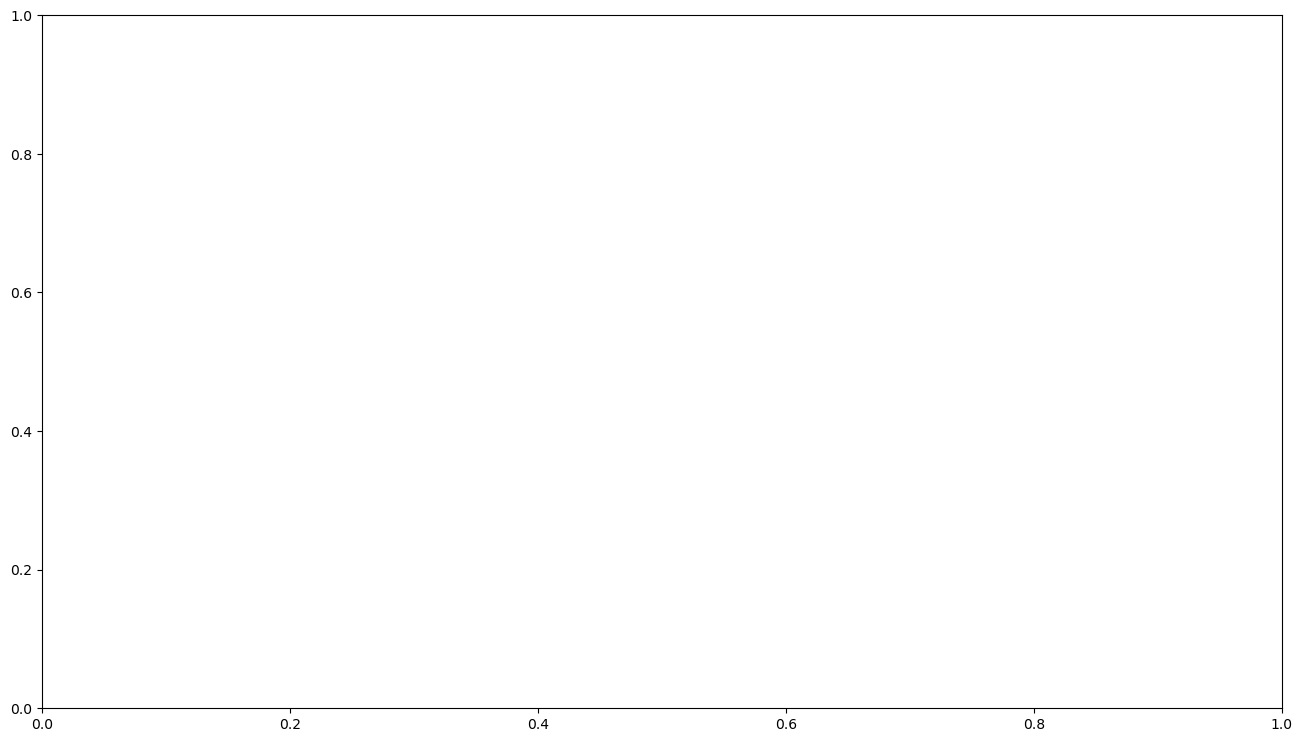

In [77]:
fig, ax = plt.subplots(figsize=(16, 9))
plot_tree(model, rankdir='LR', num_trees=1,ax=ax)
plt.show(); #visualization of another tree

ExecutableNotFound: failed to execute PosixPath('dot'), make sure the Graphviz executables are on your systems' PATH

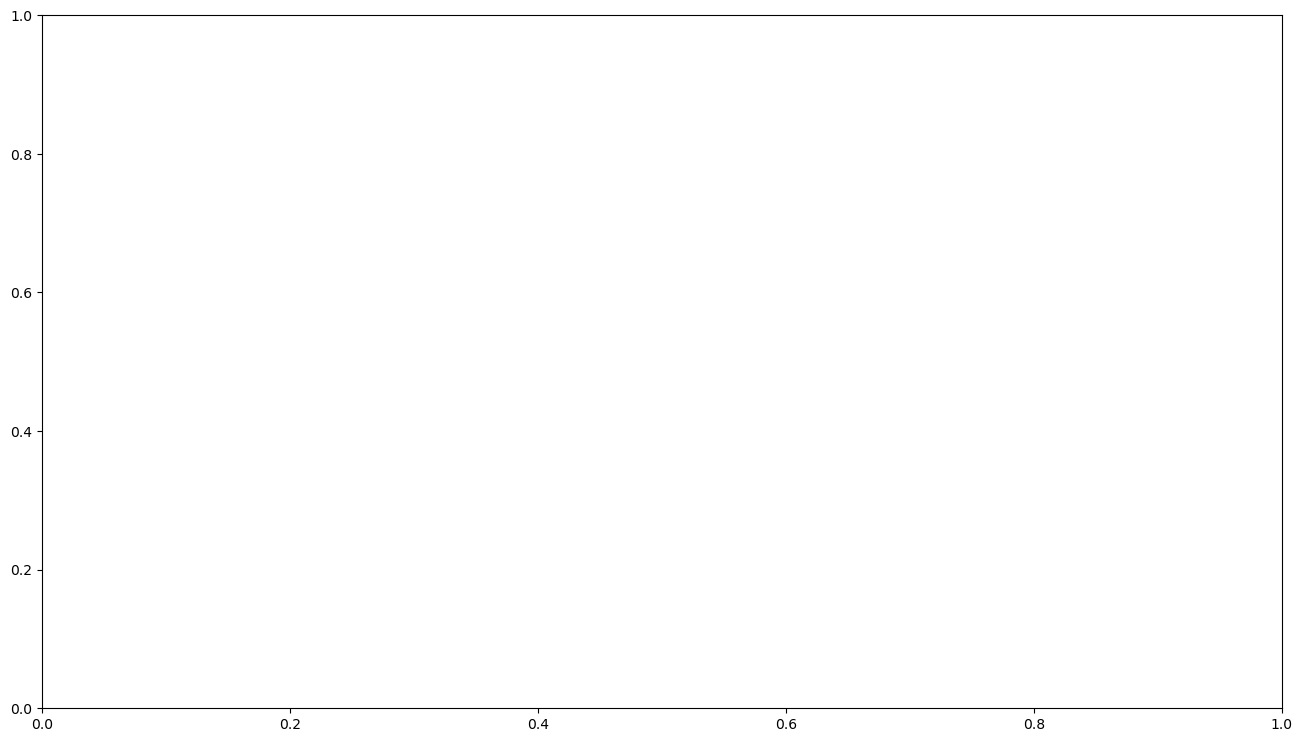

In [78]:
fig, ax = plt.subplots(figsize=(16, 9))
plot_tree(model, rankdir='LR', num_trees=19,ax=ax)
plt.show(); #visualization of another tree

Notice how the trees only compute residuals, and not the actual target value. We can also visualize the tree as text.

In [79]:
trees = model.get_booster().get_dump()

print(trees[0])

0:[Promo<0.107919127] yes=1,no=2,missing=1
	1:[StoreType_b<0.5] yes=3,no=4,missing=3
		3:[Assortment_a<0.5] yes=7,no=8,missing=7
			7:[CompetitionDistance<-0.508807302] yes=15,no=16,missing=15
				15:leaf=2309.51147
				16:leaf=1823.30444
			8:[WeekOfYear<1.65764904] yes=17,no=18,missing=17
				17:leaf=1619.43994
				18:leaf=2002.44897
		4:[CompetitionDistance<-0.427125275] yes=9,no=10,missing=9
			9:[CompetitionDistance<-0.445225298] yes=19,no=20,missing=19
				19:leaf=2740.44067
				20:leaf=5576.85889
			10:[DayOfWeek_7<0.5] yes=21,no=22,missing=21
				21:leaf=1898.36487
				22:leaf=2961.08765
	2:[DayOfWeek_1<0.5] yes=5,no=6,missing=5
		5:[Month<1.70107782] yes=11,no=12,missing=11
			11:[StoreType_b<0.5] yes=23,no=24,missing=23
				23:leaf=2295.30566
				24:leaf=3294.27759
			12:[Day<-0.556884944] yes=25,no=26,missing=25
				25:leaf=2754.58521
				26:leaf=3246.39014
		6:[Month<1.70107782] yes=13,no=14,missing=13
			13:[CompetitionDistance<-0.520873904] yes=27,no=28,missing=27
				27:

This code retrieves the text representation of all the decision trees in the trained XGBoost model `model`. The `get_booster()` method returns the underlying Booster object of the trained model, and `get_dump()` method returns the text representation of all the trees in the booster. 

Each tree in the returned list is represented as a string with its nodes and leaf values, which can be parsed to obtain the rules used by the model for prediction. This information can be useful for model interpretation and understanding, and can be used to visualize the tree structures and decision paths.

By analyzing the text representation of the trees, we can gain insights into the most important features used by the model, as well as the order and hierarchy of the decision rules. This information can help us identify any biases or inconsistencies in the model, and suggest ways to improve its performance. Additionally, the tree structures can be visualized and shared with non-technical stakeholders for better understanding and communication of the model's predictions.

# Feature importance

Just like decision trees and random forests, XGBoost also provides a feature importance score for each column in the input.

In machine learning, feature importance refers to the technique of determining which features of the input data are most relevant in predicting the output. In XGBoost, feature importance is calculated as the average gain of splits which use the feature across all trees in the ensemble. This is done by the `feature_importances_` attribute of the XGBoost model.

`model.feature_importances_` returns an array of feature importance scores, where each score corresponds to a specific input feature. The higher the score, the more important that feature is in the model's predictions. The feature importance scores can be used to identify which features have the most predictive power and can be used to create a simplified model with only the most important features, which can lead to faster predictions and improved interpretability.

Overall, `model.feature_importances_` is a useful tool for understanding the relative importance of input features in an XGBoost model and can help with feature selection and model optimization.

In [80]:
importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

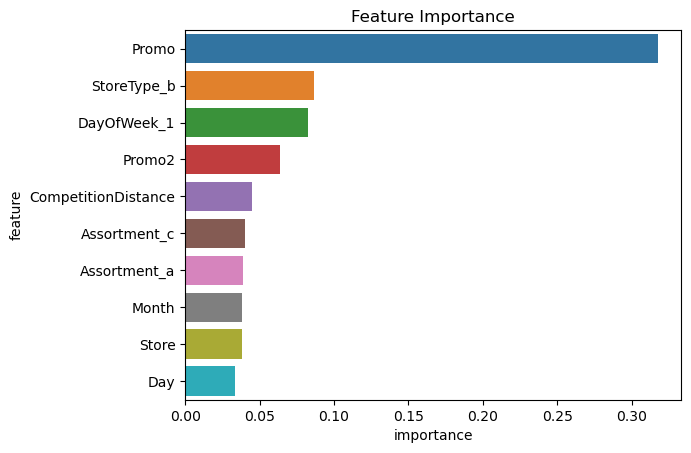

In [81]:
plt.title('Feature Importance')
sns.barplot(data=importance_df.head(10), x='importance', y='feature');

### We haven't created a validation set yet, because we'll use ***K-fold*** cross validation for this tutorial

Validation set is important to test our model's accuracy since we do not have a `test_targets` or otherwise called as `y_test` dataset it is good to create a validaton dataset.

**While working with chronological data, it's often a good idea to separate the training, validation and test sets with time, so that the model is trained on data from the past and evaluated on data from the future.**

Since for the Demonstration purpose we'll ignore that rule and use **K-fold Corss Validation**. Learn more about `K-fold` [HERE](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html).

# K Fold Cross Validation

Notice that we didn't create a validation set before training our XGBoost model. We'll use a different validation strategy this time, called K-fold cross validation ([source](https://vitalflux.com/k-fold-cross-validation-python-example/)):

![](https://vitalflux.com/wp-content/uploads/2020/08/Screenshot-2020-08-15-at-11.13.53-AM.png)

K-Fold Cross Validation is a popular technique used in machine learning to evaluate the performance of a model. It involves partitioning the dataset into k equally sized folds, where k is typically set to 5 or 10. 

In each of the k iterations, one of the folds is used as the test set, and the other k-1 folds are used as the training set. The model is trained on the training set and then evaluated on the test set. The performance metric, such as accuracy or mean squared error, is then recorded. 

This process is repeated k times, with each fold being used as the test set once. The performance metrics from the k iterations are then averaged to give an overall estimate of the model's performance. This approach helps to reduce the variance of the model by using all of the data for training and testing.

K-Fold Cross Validation is particularly useful when the dataset is small or the model has a high variance. It allows for a more robust estimation of the model's performance and helps to prevent overfitting. By repeating the process k times, the technique also helps to reduce the impact of any random variation in the training and test data.

Scikit-learn provides utilities for performing K fold cross validation. So, we are gonna import necessary libraies.

In [82]:
from sklearn.model_selection import KFold

Now, we can use the `KFold` utility to create the different training/validations splits and train a separate model for each fold. Since this cross validation is gonna be repetitive i'm gonne use a helper function to make a loop for this process. The code is explained below.

In [83]:
# Code not important just understand what we are trying to find.

models = []

def train_evaluate_and_predict(X, targets, **params): 
    kfold = KFold(n_splits=12)
    train_rmses = []
    val_rmses = []
    temp_models=[]
    n_estimators=0
    max_depth=0
    for i, (train_indexs, val_indexs) in enumerate(kfold.split(X)):
        X_train, train_targets = X.iloc[train_indexs], targets.iloc[train_indexs]
        X_val, val_targets = X.iloc[val_indexs], targets.iloc[val_indexs]
        model = XGBRegressor(random_state=42, n_jobs=-1, **params)
        model.fit(X_train, train_targets)
        train_rmse = rmse(model.predict(X_train), train_targets)
        val_rmse = rmse(model.predict(X_val), val_targets)
        temp_models.append(model)
        train_rmses.append(train_rmse)
        val_rmses.append(val_rmse)
        n_estimators=params['n_estimators']
        max_depth=params['max_depth']
        print('Iteration {}, Train RMSE: {}, Validation RMSE: {}, Hyperparameters: n_estimators {}, max_depth {}'.format(i+1, train_rmse, val_rmse,n_estimators,max_depth))
        params['n_estimators'] += 1
        params['max_depth'] += 1
    return models.append(temp_models)

This `train_evaluate_and_predict` function follows allows to automate the prediction of train and val datasets and steps are explained below:

1. `n_estimators` and `max_depth` are initialized to 0 at the beginning of the function.

2. The loop iterates over the 12 folds generated by `KFold`.

3. Inside the loop, the training and validation sets are generated using `iloc` as before.

4. A new `XGBRegressor` model is created with the `params` dictionary, which is passed using `**params`.

5. The model is trained on the training set using `fit`.

6. The root mean squared error (RMSE) is computed for both the training and validation sets using the `rmse` function.

7. The model, training RMSE, and validation RMSE are appended to the `models`, `train_rmses`, and `val_rmses` lists, respectively.

8. The current values of `n_estimators` and `max_depth` are stored in the `n_estimators` and `max_depth` variables.

9. The iteration number, training RMSE, validation RMSE, `n_estimators`, and `max_depth` are printed using `print`.

10. Finally, the `n_estimators` and `max_depth` values in the `params` dictionary are incremented by 1 using `+=`.

So, in summary, this function trains and evaluates an XGBoost model using cross-validation with 12 folds, and increments the `n_estimators` and `max_depth` hyperparameters by 1 in each iteration of the loop. The purpose of this is to see how the performance of the model changes as these hyperparameters are varied. The printed output provides information on the iteration number, the training and validation RMSEs, and the current hyperparameter values.


The `train_evaluate_and_predict_two` function takes in a feature matrix `X`, a target vector `targets`, and a dictionary of hyperparameters `params` for an XGBoost model. It then performs k-fold cross-validation (with `k=10` by default) and trains an XGBoost model on each fold of the data, incrementing the `n_estimators` and `max_depth` hyperparameters by 1 in each iteration of the loop.

Here's a more detailed breakdown of what the function does:

1. Initialize the `models`, `train_rmses`, and `val_rmses` lists to store the trained models and their respective train and validation RMSEs.
2. Set `n_estimators` and `max_depth` variables to 0 (these will be used to keep track of the current values of these hyperparameters).
3. Loop over the folds of the data using `KFold.split(X)`. For each fold:
   1. Split the data into training and validation sets.
   2. Create an XGBoost model using the specified hyperparameters in `params`.
   3. Train the XGBoost model on the training data and compute the train and validation RMSEs.
   4. Append the trained model to the `models` list, and append the train and validation RMSEs to the `train_rmses` and `val_rmses` lists.
   5. Print out the current iteration number, train RMSE, validation RMSE, and the current values of `n_estimators` and `max_depth`.
   6. Increment the `n_estimators` and `max_depth` hyperparameters by 1 for the next iteration of the loop.
4. Return the `models`, `train_rmses`, and `val_rmses` lists.

In [84]:
train_evaluate_and_predict(X,targets,n_estimators=5,max_depth=4)

Iteration 1, Train RMSE: 2887.1302541155446, Validation RMSE: 2993.5218863008226, Hyperparameters: n_estimators 5, max_depth 4
Iteration 2, Train RMSE: 2662.950032818485, Validation RMSE: 2874.6434627607014, Hyperparameters: n_estimators 6, max_depth 5
Iteration 3, Train RMSE: 2483.017624186957, Validation RMSE: 2663.1345199508246, Hyperparameters: n_estimators 7, max_depth 6
Iteration 4, Train RMSE: 2368.969970251371, Validation RMSE: 2370.5908489991493, Hyperparameters: n_estimators 8, max_depth 7
Iteration 5, Train RMSE: 2234.3311220892833, Validation RMSE: 2161.7648436553905, Hyperparameters: n_estimators 9, max_depth 8
Iteration 6, Train RMSE: 2020.4127575469652, Validation RMSE: 2204.3961890177848, Hyperparameters: n_estimators 10, max_depth 9
Iteration 7, Train RMSE: 1909.698103092894, Validation RMSE: 1834.7153233997599, Hyperparameters: n_estimators 11, max_depth 10
Iteration 8, Train RMSE: 1602.2714158153487, Validation RMSE: 2118.4972467527036, Hyperparameters: n_estimators 

As we can see that `train rmse` and `val rmse` starts to come down when we incease the no. of estimators i.e `trees` and `max_depth` that's expected as the model is getting more decision trees to predict and average on the output. But we can also see that this effect only happens to a certain point. On the `11th Iteration` we start to see that the _train rmse_ decreases while the _val rmse_ increases. This shows that the model starts to overfit to the training data. I suspect that this is more of a cause of increasing the `max_depth` rather than `n_estimators`. This way we can experiment with various parameters to see the best set of `hyperparameters` for our model.

### **This is where programming helps. it allows us to write codes like this to automate the multiple model creating with just a click. We don't require fancy programming skills like a software developer have. It's always good to know the basic function creation, data types, basic syntaxes. This knowledge of programing is enough to breakdown complex or repetitive tasks into a function which will make the code a lot simple and saves time.**

# Hyperparameter Tuning and Regularization

Just like other machine learning models, there are several hyperparameters we can to adjust the capacity of model and reduce overfitting.



Hyperparameter tuning and regularization are two important techniques used in machine learning to improve the performance of models.

Hyperparameter tuning involves adjusting the settings or parameters of a machine learning algorithm that are not learned from data. These settings can have a significant impact on the performance of the algorithm. For example, in a neural network, the number of layers, the number of nodes in each layer, the learning rate, and the batch size are all hyperparameters that can be tuned to improve the model's performance. There are several approaches to hyperparameter tuning, including **grid search, random search, and Bayesian optimization**. Grid search involves systematically trying out all possible combinations of hyperparameters, while random search selects hyperparameters randomly from a given range. Bayesian optimization is a more sophisticated approach that uses a probabilistic model to guide the search for optimal hyperparameters.

Regularization, on the other hand, is a technique used to prevent overfitting in machine learning models. Overfitting occurs when a model performs well on the training data but poorly on new, unseen data. Regularization helps to prevent overfitting by adding a penalty term to the loss function that encourages the model to have smaller weights or simpler solutions. There are several types of regularization, including **L1 regularization (also known as Lasso), L2 regularization (also known as Ridge), and dropout**. L1 regularization adds a penalty term to the loss function that is proportional to the absolute value of the weights, while L2 regularization adds a penalty term that is proportional to the square of the weights. Dropout is a technique that randomly drops out (sets to zero) some of the neurons in a neural network during training, which can help prevent overfitting.

Hyperparameter tuning and regularization are both important techniques for improving the performance of machine learning models. By tuning the hyperparameters and applying regularization techniques, it is possible to create models that generalize well to new, unseen data.

Read more about general Hyper-parameter tuning [HERE](https://scikit-learn.org/stable/modules/grid_search.html) and,
Read more about general Regularisation [HERE](https://medium.com/coinmonks/regularization-of-linear-models-with-sklearn-f88633a93a2).

<img src="https://i.imgur.com/EJCrSZw.png" width="480">

Check out the following resources to learn more about hyperparameter supported by XGBoost:

- https://xgboost.readthedocs.io/en/latest/python/python_api.html#xgboost.XGBRegressor
- https://xgboost.readthedocs.io/en/latest/parameter.html

In [85]:
# our current model we've using till now.
model

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=20, n_jobs=-1, num_parallel_tree=None, predictor=None,
             random_state=42, ...)

Since it may take a long time to perform training and prediction for each set of parameters we wish to try, we'll just pick a random 10% sample of the dataset as the validation set. For this i used `train_test` split from sklearn. this is used to split any dataset into train and test datasets.

Your can read more about `train_test_split` [HERE](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html).


After that we use a very similar function that we used above without **K-flod** to test the following hyperparameters.

In [86]:
from sklearn.model_selection import train_test_split

X_train, X_val, train_targets, val_targets = train_test_split(X, targets, test_size=0.1)

In [87]:
def test_params(**params): 
    model = XGBRegressor(n_jobs=-1, random_state=42, **params)
    model.fit(X_train, train_targets)
    train_rmse = rmse(model.predict(X_train), train_targets)
    val_rmse = rmse(model.predict(X_val), val_targets)
    print('Train RMSE: {}, Validation RMSE: {}'.format(train_rmse, val_rmse))

This function takes in a dictionary of parameters (`**params`) as input and uses them to train and evaluate a gradient boosting model using the XGBRegressor class from the XGBoost library.

The function first creates an instance of the XGBRegressor class with three fixed hyperparameters: `n_jobs=-1` specifies that all available CPU cores should be used for training, `random_state=42` sets the random seed for reproducibility, and `**params` passes any additional hyperparameters to the model as a dictionary.

The XGBRegressor model is then trained using the `model.fit(X_train, train_targets)` method, where `X_train` is the training feature matrix and `train_targets` are the corresponding target values.

Next, the function calculates the root mean squared error (RMSE) between the predicted and actual target values for both the training and validation datasets, using a custom `rmse` function that is not shown in the code snippet. The RMSE metric is a common evaluation metric used for regression models, which measures the average distance between the predicted and actual target values, with lower values indicating better performance.

Finally, the function prints the training and validation RMSE scores using the `print` function. These scores provide a measure of how well the model is performing on both the training and validation datasets.

Overall, this function is a convenient way to test different hyperparameters for a gradient boosting model and evaluate their performance on a training and validation dataset. By passing different hyperparameters to the function, users can quickly experiment with different model configurations and identify the best combination of hyperparameters that results in the lowest RMSE score on the validation dataset.

### We'll try changing some of the parameters and see their effects below:

#### 1. `n_estimators`

The number of trees to be created. More trees = greater capacity of the model.


In [77]:
test_params(n_estimators=10)

Train RMSE: 2376.2174987396097, Validation RMSE: 2369.5159258630297


In [78]:
test_params(n_estimators=30)

Train RMSE: 1921.651097796041, Validation RMSE: 1916.5091469929498


In [79]:
test_params(n_estimators=50)

Train RMSE: 1553.8809802096725, Validation RMSE: 1548.508822442032


Notice the RMSE decrease as we change the value of the n_estimators?

Also remmeber the graph that we cannot just keep on increasing the n_estimators as at certain point the `train rmse` will keep on decrease while the `val rmse` will keep on increase. This is what it's called as "model overfitting" 

Model overfitting is a common problem in machine learning, where a model performs very well on the training data but poorly on new, unseen data. In other words, the model memorizes the training data rather than learning the underlying patterns that would allow it to generalize well to new data. 

Overfitting occurs when a model is too complex relative to the amount and quality of the training data. When a model is too complex, it can fit the noise in the training data, which leads to poor performance on new data. Overfitting can also occur when a model is trained for too long, which can lead to the model memorizing the training data instead of learning the underlying patterns.

Overfitting can be detected by comparing the model's performance on the training data to its performance on a separate validation dataset. If the model's performance on the validation data is significantly worse than its performance on the training data, the model is likely overfitting. 

There are several methods to avoid overfitting in XGBoost which we'll discuss later.

#### 2. `max_depth`

As you increase the max depth of each tree, the capacity of the tree increases and it can capture more information about the training set.

In [80]:
test_params(max_depth=2)

Train RMSE: 2356.05765092111, Validation RMSE: 2347.683383292126


In [81]:
test_params(max_depth=5)

Train RMSE: 1423.4145365672364, Validation RMSE: 1423.9855457866952


In [82]:
test_params(max_depth=10)

Train RMSE: 694.7794340111157, Validation RMSE: 782.3470976965974


#### 3.`learning_rate`

The scaling factor to be applied to the prediction of each tree. A very high learning rate (close to 1) will lead to overfitting, and a low learning rate (close to 0) will lead to underfitting.

In XGBoost, the learning rate is a hyperparameter that controls the step size at each iteration while moving toward a minimum of a loss function. The learning rate shrinks the feature weights in order to make the boosting process more conservative. The smaller the learning rate, the smaller steps the model takes and the more accurate the predictions, but this comes at the cost of longer training times.

A high learning rate can lead to faster training times but can also result in the model overshooting the optimal solution and ultimately leading to poorer performance. On the other hand, a low learning rate can help the model converge to the optimal solution, but it may take many iterations and result in longer training times.

Therefore, choosing the optimal learning rate is important to achieve both faster convergence and better performance. A typical range of learning rates for XGBoost is between 0.01 and 0.2, but the optimal value may depend on the specific problem being solved and other hyperparameters in the model. It's a good practice to experiment with different learning rates to find the optimal value for a given problem.

In [83]:
test_params(n_estimators=50, learning_rate=0.01)

Train RMSE: 5045.117320682507, Validation RMSE: 5022.586271402943


In [84]:
test_params(n_estimators=50, learning_rate=0.1)

Train RMSE: 2190.184525396884, Validation RMSE: 2187.404792127559


In [85]:
test_params(n_estimators=50, learning_rate=0.3)

Train RMSE: 1553.8809802096725, Validation RMSE: 1548.508822442032


In [86]:
test_params(n_estimators=50, learning_rate=0.9)

Train RMSE: 1115.080950761249, Validation RMSE: 1118.0438064027983


In [87]:
test_params(n_estimators=50, learning_rate=0.99)

Train RMSE: 1150.8866452168586, Validation RMSE: 1154.9085144468902


#### 4. `booster`

Instead of using Decision Trees, XGBoost can also train a linear model for each iteration. This can be configured using `booster`.

In XGBoost, the term "booster" refers to the type of model that is used for boosting. There are two types of boosters available in XGBoost: tree and linear.

The tree booster is a decision tree-based model that recursively splits data based on certain criteria, while the linear booster is a linear model that uses regularized linear regression. 

The default booster in XGBoost is "tree", which means the model will be a decision tree-based model. However, the "linear" booster can also be used if the data has a linear structure or if the number of features is very high.

In addition to the type of booster, XGBoost also allows for customization of the booster's parameters, such as the learning rate, maximum depth, and number of trees. These parameters can be tuned to improve the performance of the model.

In [88]:
test_params(booster='gblinear')

Train RMSE: 2728.1034553267777, Validation RMSE: 2719.9203427308034


Clearly, a linear model is not well suited for this dataset.

Similarly you can exeperiment with other hyperparameters like `gamma`, `min_child_weight`, `max_delta_step`, `subsample`, `colsample_bytree` etc. and find their optimal values. Learn more about them here: https://xgboost.readthedocs.io/en/latest/python/python_api.html#xgboost.XGBRegressor

### these helprer functions we create to find the best parameters from a set of parameters we gave as input:

**In machine learning "It's called as HYPERPARAMETER TUNING"**

Hyperparameter tuning refers to the process of selecting the optimal values for the hyperparameters of a machine learning model. Hyperparameters are parameters that are not learned during the training process but are set before training begins. Examples of hyperparameters in XGBoost include the learning rate, maximum depth of a tree, number of trees in the ensemble, regularization parameters, and more.

Hyperparameter tuning is important because it can significantly impact the performance of a model. Selecting appropriate values for hyperparameters can help to avoid overfitting or underfitting, and can improve the accuracy, precision, and recall of the model.

There are two main types of hyperparameter tuning: manual tuning and automated tuning.

1. **Manual tuning**: In manual tuning, the hyperparameters are selected based on the domain knowledge and experience of the user. The user tries different combinations of hyperparameters and evaluates the model's performance. The process can be time-consuming and requires a good understanding of the model and its hyperparameters.

2. **Automated tuning**: Automated tuning involves the use of algorithms to automatically search for the best hyperparameters. This can be done using techniques such as grid search, random search, or Bayesian optimization. Grid search involves specifying a range of values for each hyperparameter and trying all possible combinations. Random search involves randomly selecting hyperparameters from a given range of values. Bayesian optimization is a more sophisticated technique that uses a probabilistic model to search for the optimal hyperparameters.

Automated tuning is generally faster and can lead to better performance than manual tuning, but it requires more computational resources and may not always find the optimal hyperparameters. It is important to note that hyperparameter tuning is an iterative process and should be done in conjunction with other model selection and evaluation techniques such as cross-validation to ensure the model's performance is optimized.

# Putting it Together and Making Predictions

Let's train a final model on the entire training set with custom hyperparameters. 

In [89]:
# This is the final model i've created.
model = XGBRegressor(n_jobs=-1, random_state=42,n_estimators=1000,   # Some parameters I think will be good 
                     learning_rate=0.2, max_depth=10, subsample=0.9, 
                     colsample_bytree=0.7)

But Training it on the entire dataset will take a very long time. Thus i'm gonna test it's accuracy on a sample `train` dataset with only 20% of the whole dataset while`test` dataset is only 10% of the total dataset using the code below.

In [90]:
X_train, X_val, train_targets, val_targets = train_test_split(X, targets, test_size=0.1,train_size=0.2) 

model.fit(X_train, train_targets)
train_rmse = rmse(model.predict(X_train), train_targets)
val_rmse = rmse(model.predict(X_val), val_targets)
    
print("Train RMSE: {} and Validation RMSE: {}".format(train_rmse,val_rmse))

Train RMSE: 153.89664861282228 and Validation RMSE: 811.951361617709


Even that took quite a lot of time. So the actual model on the enite dataset will take hours to complete. One way to speed up the process in the usage of **GPU** instead of CPU for prediction.

In Machine Learning (ML), training models on large datasets can be a computationally intensive task that requires a lot of processing power. As a result, using a Graphics Processing Unit (GPU) instead of a Central Processing Unit (CPU) can significantly speed up the training process.

The reason for this is that GPUs are designed to handle massive amounts of parallel computations, which is exactly what is needed in ML when performing matrix operations, convolutions, and other mathematical computations on large datasets. CPUs, on the other hand, are optimized for single-threaded performance and are less efficient at parallel computations.

Using GPUs can accelerate training times by several orders of magnitude, enabling researchers to experiment with more complex models, larger datasets, and more hyperparameters. Additionally, GPUs can be used for real-time predictions in applications such as self-driving cars, where decisions need to be made in real-time based on input from sensors.

---------------------------------------------------------------------------------------------------------------------------------------------------------
One of the resources available on Kaggle is the ability to use GPU accelerators to speed up training of deep learning models.

GPU accelerators are specialized hardware devices that are designed to perform complex mathematical computations required for deep learning models. They are much faster than traditional CPUs because they can process many computations in parallel.

Kaggle provides access to GPU accelerators through its kernel environments, which are preconfigured virtual machines that include popular machine learning libraries like TensorFlow and PyTorch. Kaggle provides GPU-enabled kernel environments for free to all users, and participants can choose from a variety of GPU types and configurations depending on their needs.

Using GPU accelerators in Kaggle can significantly speed up the training process for deep learning models, allowing participants to iterate and experiment with different model architectures and hyperparameters more quickly. This can be especially important for large datasets or complex models that require many iterations to converge on an optimal solution.

In addition to Kaggle, many other cloud-based machine learning platforms also provide access to GPU accelerators, such as Google Colab, Amazon Web Services, and Microsoft Azure.

# End of XGBoost Intuition

# Model training on GPU

## First 

on the top right of the kaggle notebook select the desired GPU from the three-dots-menu=>Accelrator=>select the prefered one.

I'm gonna use `GPU P100` as it is the most powerfull one available in kaggle.

## Note:

Since we are working on a competition dataset it would nice to submit a result with all the learnings we accuired through this dataset. Thus The below cells will contribute to that. If you wanna learn XGBoost see the cells above. If u wanna know more about submitting for a competition in kaggle follow along from here.

This Building the below models will take huge amount of **Time** and **CPU/GPU Power** Thus it is recommend to use ur personal $PC$ to train the model and modify whatever you want before finally submitting to the competition.

Also since this will take a long time i'm gonna use the available **GPU Accelerator** in kaggle. 

### REMMEMBER a user can use 30hrs of GPU per Week in kaggle.

Also GPU will mostly be activated for workflows like Tensorflow,keras. And most of the time it wont be activated even if we are training on some really large datasets. There are several methods to make each model make use of the GPU available.

For general activation of GPU on ur PC for tensorflow and keras u can use the guide [HERE](https://www.techentice.com/how-to-make-jupyter-notebook-to-run-on-gpu/). This worked for me and was easy to follow.

But this doesn't straightaway activate gpu for models like linear regression,decision trees,logistic regression etc. Each one of them will require to some methods for activation. Thus i'd recommend you to google it up whenever necessary. For now we can see how to activate and run XGBRegssor on GPU, Fortunately this is fairly simple which is explained below.

In [99]:
# our current model
model = XGBRegressor(n_jobs=-1, random_state=42,n_estimators=1000,   # Some parameters I think will be good 
                     learning_rate=0.2, max_depth=10, subsample=0.9, 
                     colsample_bytree=0.7,tree_method = 'gpu_hist') 

# this command (tree_method = ‘gpu_hist’) will make the model to use the available GPU for XGBRegressor.

In [101]:
%%time
model.fit(X, targets)
train_rmse = rmse(model.predict(X_train), train_targets)
val_rmse = rmse(model.predict(X_val), val_targets)
print("Train RMSE: {} and Validation RMSE: {}".format(train_rmse,val_rmse))

Train RMSE: 385.245662918138 and Validation RMSE: 385.1908959616399
CPU times: user 42.5 s, sys: 274 ms, total: 42.8 s
Wall time: 31 s


see just `31secs` wasn't that lightling fast? to put it in prespective lets also see the time taken the same mode is trained on the cpu alone.

In [102]:
model = XGBRegressor(n_jobs=-1, random_state=42,n_estimators=1000,   # Some parameters I think will be good 
                     learning_rate=0.2, max_depth=10, subsample=0.9, 
                     colsample_bytree=0.7)  #without the (tree_method = ‘gpu_hist’) command

In [103]:
%%time
model.fit(X, targets)
train_rmse = rmse(model.predict(X_train), train_targets)
val_rmse = rmse(model.predict(X_val), val_targets)
print("Train RMSE: {} and Validation RMSE: {}".format(train_rmse,val_rmse))

Train RMSE: 388.43928342782175 and Validation RMSE: 387.2502657428061
CPU times: user 53min 14s, sys: 6.05 s, total: 53min 20s
Wall time: 27min 46s


**That's a very very huge time difference with little to no accuracy difference. This is why training large datasets on the gpu is very much important. Since this takes lets time it allows us to try and experiment with different parameters,functions, validations whatever we try to improve our model.**

# Disclaimer
I've experimented with different solutions for this competition submission. From which i'm going to impliment one of the better trained model and prediction below. Somethings might be unclear other can be confusing but, it is so similar to what we've done above. Just that it'll be some superfied version of what we've done so far. 

We can submit two score for our final submission. Thus i'm gonna use 2 types of methods in which `XGBOOST` can be used for this prediction.
## please
don't try to use my predictions and submit the same to the competition. That'll bring no knowledge. I already saw on the leaderboard that many of them did that thing just to make their names appear on the leaderboard. That is not at all a good pracise when you are trying to learn. Feel free to fork my notebook make some changes that you think would further increase the accuracy of model. This way u'll learn a lot not in writing the code but also how to train models analytically. With that said let's start

# Submission for the Rossman Sales Compettion

**Since the score is affected by each and every modifcation we do right from importing the dataset, i'm gonna do Every process from the start.**

**Also I wont be giving commentary inbetween code block like i did on the tutorial above. If it's really needed i'll write them anyway**

## Loading Necessay Libraries

In [ ]:
import numpy as np
import pandas as pd
pd.set_option("display.max_columns", 120)

## Importing required datasets

In [104]:
ross_df = pd.read_csv('/kaggle/input/rossmann-store-sales/train.csv', low_memory=False)
store_df = pd.read_csv('/kaggle/input/rossmann-store-sales/store.csv')
test_df = pd.read_csv('/kaggle/input/rossmann-store-sales/test.csv')
submission_df = pd.read_csv('/kaggle/input/rossmann-store-sales/sample_submission.csv')

## Overviewing the datasets

In [105]:
ross_df

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1
...,...,...,...,...,...,...,...,...,...
1017204,1111,2,2013-01-01,0,0,0,0,a,1
1017205,1112,2,2013-01-01,0,0,0,0,a,1
1017206,1113,2,2013-01-01,0,0,0,0,a,1
1017207,1114,2,2013-01-01,0,0,0,0,a,1


In [106]:
store_df

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
1110,1111,a,a,1900.0,6.0,2014.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct"
1111,1112,c,c,1880.0,4.0,2006.0,0,NaN,NaN,NaN
1112,1113,a,c,9260.0,NaN,NaN,0,NaN,NaN,NaN
1113,1114,a,c,870.0,NaN,NaN,0,NaN,NaN,NaN


In [107]:
test_df

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1.0,1,0,0
1,2,3,4,2015-09-17,1.0,1,0,0
2,3,7,4,2015-09-17,1.0,1,0,0
3,4,8,4,2015-09-17,1.0,1,0,0
4,5,9,4,2015-09-17,1.0,1,0,0
...,...,...,...,...,...,...,...,...
41083,41084,1111,6,2015-08-01,1.0,0,0,0
41084,41085,1112,6,2015-08-01,1.0,0,0,0
41085,41086,1113,6,2015-08-01,1.0,0,0,0
41086,41087,1114,6,2015-08-01,1.0,0,0,0


## Checking Missing Values

In [108]:
ross_df.isna().sum()

Store            0
DayOfWeek        0
Date             0
Sales            0
Customers        0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
dtype: int64

In [109]:
test_df.isna().sum()

Id                0
Store             0
DayOfWeek         0
Date              0
Open             11
Promo             0
StateHoliday      0
SchoolHoliday     0
dtype: int64

In [111]:
store_df.isna().sum()

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64

we have `11` NA in test_df and quite a lot in store_df. I'm gonna fill/impute the NA in store_df and test_df before merging unlike we did on the tutorial.

for that i'm gonna use a function to evenly impute the missing values with affecting the nature of the dataset much.

## Imputing Missing Values

In [119]:
print('Before Imputing CompetitionDistance:\n\n{}'.format(store_df['CompetitionDistance'].describe()))

Before Imputing CompetitionDistance:

count     1112.000000
mean      5404.901079
std       7663.174720
min         20.000000
25%        717.500000
50%       2325.000000
75%       6882.500000
max      75860.000000
Name: CompetitionDistance, dtype: float64


In [120]:
# Defining a function to randomly impute missing values with the values from the range between "min, 25%, 50%, and 75%"
def random_impute(column):
    # Compute the summary statistics of the column
    summary = column.describe()
    # Generate random values from the range between "min, 25%, 50%, and 75%"
    imputed_values = np.random.choice([summary['min'], summary['25%'], summary['50%']], size=column.isna().sum())
    # Replace the missing values with the imputed values
    column_copy = column.copy()
    column_copy.loc[column.isna()] = imputed_values
    return column_copy

store_df['CompetitionDistance'] = random_impute(store_df['CompetitionDistance'])

In [121]:
print('After Imputing CompetitionDistance:\n\n{}'.format(store_df['CompetitionDistance'].describe()))

After Imputing CompetitionDistance:

count     1115.000000
mean      5394.547085
std       7655.655107
min         20.000000
25%        715.000000
50%       2325.000000
75%       6875.000000
max      75860.000000
Name: CompetitionDistance, dtype: float64


We can see a slight change in the there is a slight change in `mean` and `standard deviation` but that's not that significant. Also I thought it was a good idea to impute this `3` missing values before merging cause after merging it'll become `300+` values and imputing at that time will cause a lot of descripencies.

<AxesSubplot: >

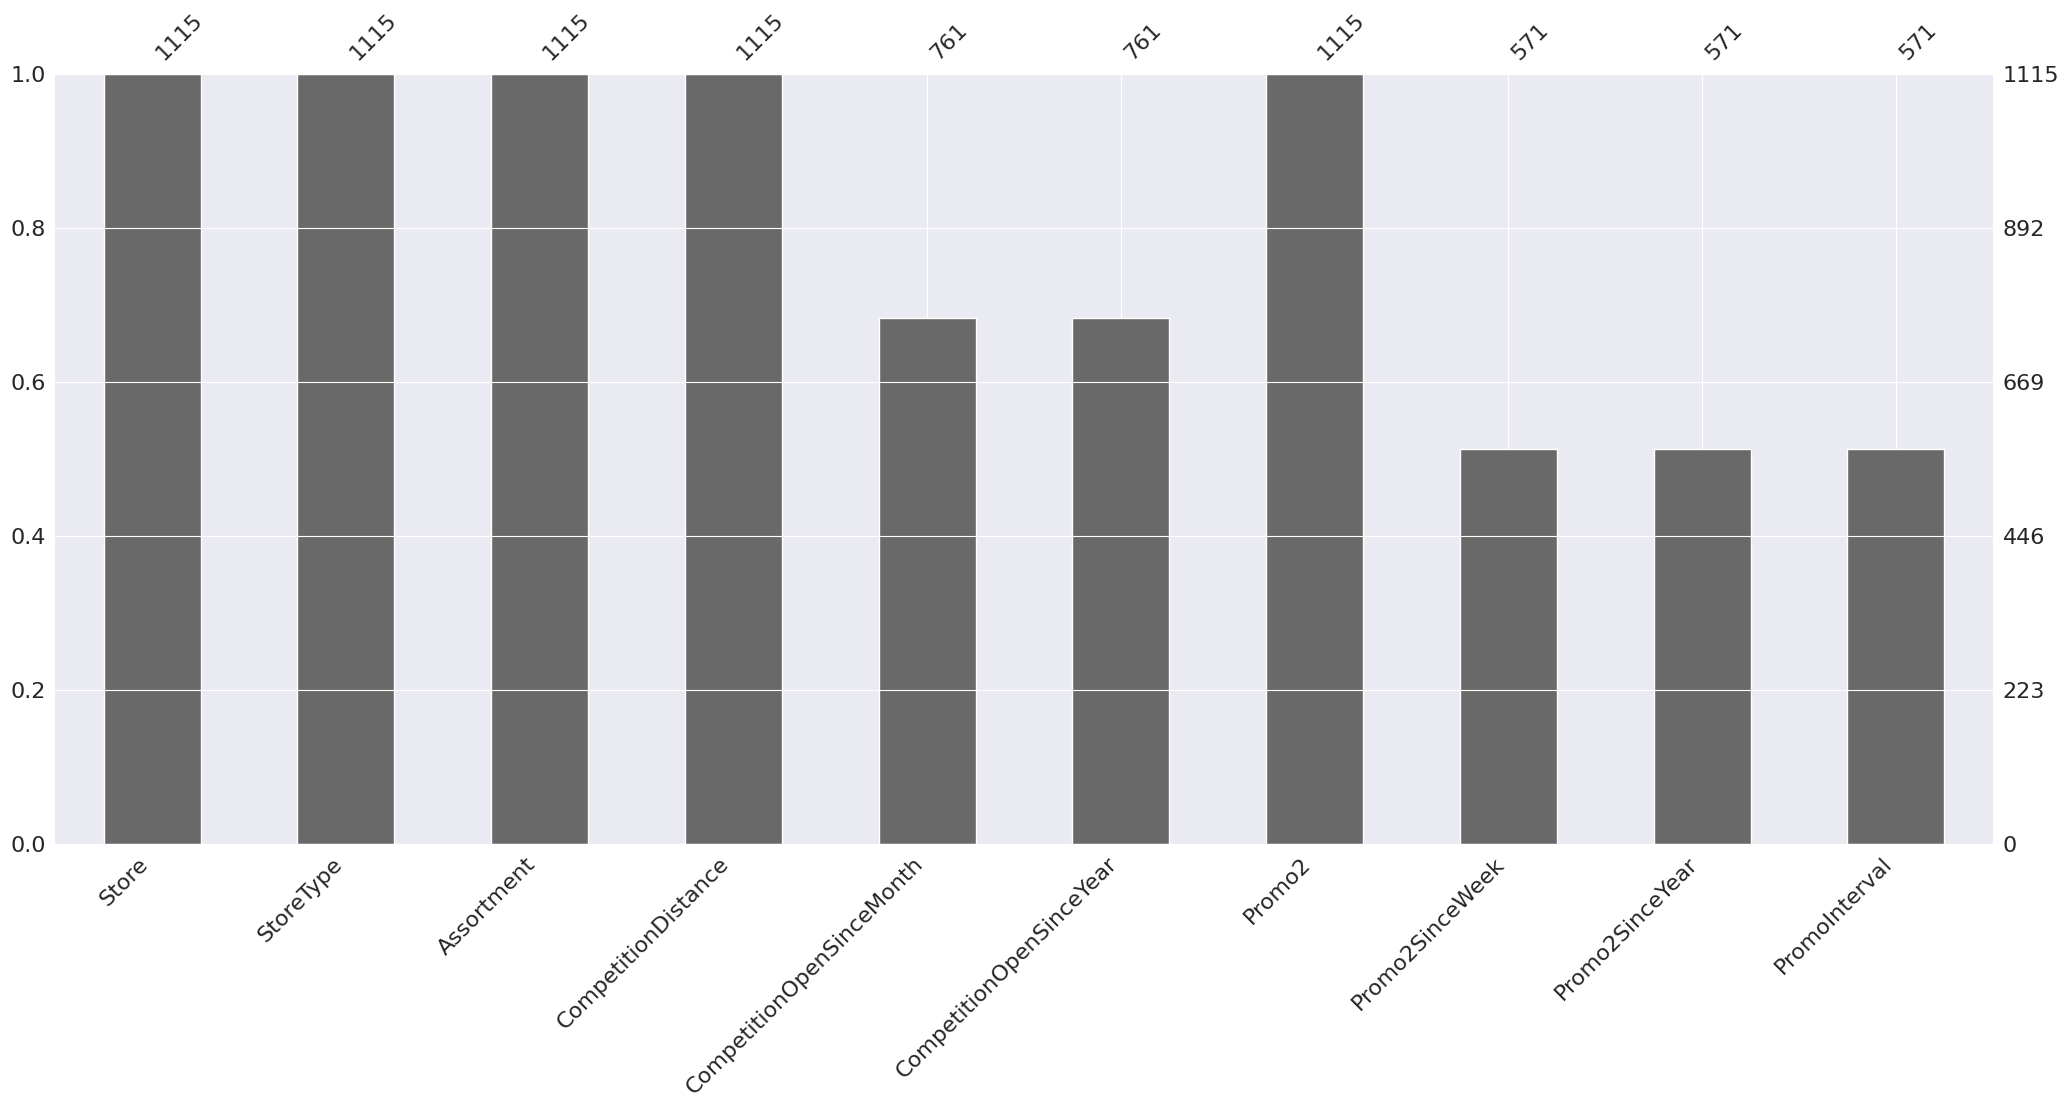

In [122]:
import missingno as msno

msno.bar(store_df)

As a general and better rule it is recommended to remove the columns with missing values more than `50%` as it will cause more chaos than do good to the model. Here we can see that the $promosinceweek$ , $promotsinceyear$ and $promointerval$ are exactly sitting on **50%** of missing data. Also we can see that $Competitionopensincemonth$ and $Competitionopensinceyear$ is sitting around **60%** of missing data. Thus, i tried to remove these altogether and trained a model on remaning columns. Well, it was so to say the predictions actually improved than what we did on the tutorial. 

But on another Iteration i tried to include the the above columns and slightly modify the imputation that yieled even good results thus. Here, too i'm gonna include those column but gonna impute them with `0` since those information can't be replicated in a good way. if we do that'll skew our model and it's not a good practise.

In [123]:
print('before filling NAs:\n\n{}'.format(store_df.isna().sum()))

before filling NAs:

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            0
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64


In [124]:
store_df=store_df.fillna(0)

In [125]:
print('After filling NAs:\n\n{}'.format(store_df.isna().sum()))

After filling NAs:

Store                        0
StoreType                    0
Assortment                   0
CompetitionDistance          0
CompetitionOpenSinceMonth    0
CompetitionOpenSinceYear     0
Promo2                       0
Promo2SinceWeek              0
Promo2SinceYear              0
PromoInterval                0
dtype: int64


Similarly test_df was having`11` NA rows in **Open** column. I imputed them as `1` why cause, I saw the 2 things that detemined where the store is opened or not was the `Sales` and `Dayofweek`. But we don't have the sales column in our test dataset. Thus i ploted a graph to make this clear.

Also i checked what was the `Dayofweek` where we have NA values.

<AxesSubplot: xlabel='DayOfWeek'>

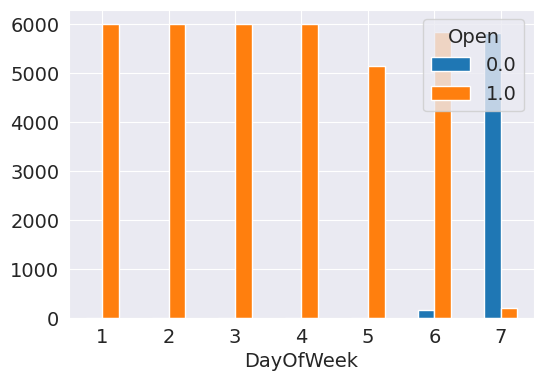

In [130]:
import matplotlib.pyplot as plt
CrosstabResult=pd.crosstab(index=test_df['DayOfWeek'],columns=test_df['Open'])
CrosstabResult.plot.bar(figsize=(6,4),rot=0)

In [131]:
test_df[test_df['Open'].isnull()]

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
479,480,622,4,2015-09-17,NaN,1,0,0
1335,1336,622,3,2015-09-16,NaN,1,0,0
2191,2192,622,2,2015-09-15,NaN,1,0,0
3047,3048,622,1,2015-09-14,NaN,1,0,0
4759,4760,622,6,2015-09-12,NaN,0,0,0
5615,5616,622,5,2015-09-11,NaN,0,0,0
6471,6472,622,4,2015-09-10,NaN,0,0,0
7327,7328,622,3,2015-09-09,NaN,0,0,0
8183,8184,622,2,2015-09-08,NaN,0,0,0
9039,9040,622,1,2015-09-07,NaN,0,0,0


see none of the `dayofweek` was 7 i.e _Sunday_ thus i arked all as `1` i.e shop is open.

In [132]:
print("before fillna:{}".format(test_df.isna().sum().sum()))
test_df=test_df.fillna(1)
print("before fillna:{}".format(test_df.isna().sum().sum()))

before fillna:11
before fillna:0


## Filtering Dataset (Same Hardcoding Idea we followed in the tutorial)

In [133]:
ross_df.loc[(ross_df.Open == 0) & (ross_df.Sales > 0)] # Since sales is zero when 'open' is 0.
# i'm assuming that when Open is 0 then sales will be zero.

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday


In [134]:
test_sales_zero=test_df.loc[(test_df.Open == 0)] # saving open 0 seperately

print("before filter ross_df:{},test_df:{}".format(ross_df.shape,test_df.shape))

test_df=test_df.loc[(test_df.Open != 0)] 
ross_df=ross_df.loc[(ross_df.Open != 0)]
                    
print("after filter ross_df:{},test_df:{}".format(ross_df.shape,test_df.shape))                    

before filter ross_df:(1017209, 9),test_df:(41088, 8)
after filter ross_df:(844392, 9),test_df:(35104, 8)


## Merging Datasets

In [135]:
merged_df = ross_df.merge(store_df, how='left', on='Store') #this is gonna be the merged training dataset
merged_test_df = test_df.merge(store_df, how='left', on='Store') #this is gonna be the merged testing dataset

In [136]:
merged_df

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,0.0,0.0,0
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
844387,682,2,2013-01-01,3375,566,1,0,a,1,b,a,150.0,9.0,2006.0,0,0.0,0.0,0
844388,733,2,2013-01-01,10765,2377,1,0,a,1,b,b,860.0,10.0,1999.0,0,0.0,0.0,0
844389,769,2,2013-01-01,5035,1248,1,0,a,1,b,b,840.0,0.0,0.0,1,48.0,2012.0,"Jan,Apr,Jul,Oct"
844390,948,2,2013-01-01,4491,1039,1,0,a,1,b,b,1430.0,0.0,0.0,0,0.0,0.0,0


## Feature Engineering

### Splitting Date

In [137]:
def split_date(df): #A helper function that takes a df and finds the Date column and extract the necessary info.
    df['Date'] = pd.to_datetime(df['Date'])
    df['Year'] = df.Date.dt.year
    df['Month'] = df.Date.dt.month
    df['Day'] = df.Date.dt.day
    df['WeekOfYear'] = df.Date.dt.isocalendar().week  #since we have day of the week already let's extrac the rest

In [138]:
split_date(merged_df)
split_date(merged_test_df)

merged_df

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month,Day,WeekOfYear
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,2015,7,31,31
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct",2015,7,31,31
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",2015,7,31,31
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,0.0,0.0,0,2015,7,31,31
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,0.0,0.0,0,2015,7,31,31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
844387,682,2,2013-01-01,3375,566,1,0,a,1,b,a,150.0,9.0,2006.0,0,0.0,0.0,0,2013,1,1,1
844388,733,2,2013-01-01,10765,2377,1,0,a,1,b,b,860.0,10.0,1999.0,0,0.0,0.0,0,2013,1,1,1
844389,769,2,2013-01-01,5035,1248,1,0,a,1,b,b,840.0,0.0,0.0,1,48.0,2012.0,"Jan,Apr,Jul,Oct",2013,1,1,1
844390,948,2,2013-01-01,4491,1039,1,0,a,1,b,b,1430.0,0.0,0.0,0,0.0,0.0,0,2013,1,1,1


### Creating 'CompetitionOpen' Column

In [139]:
"""
This code creates a new feature called 'CompetitionOpen' in the input DataFrame, 
which represents the number of months that the competition for a given store has been open.

The function takes as input a DataFrame with columns 'Year', 'Month', 'CompetitionOpenSinceYear', and 'CompetitionOpenSinceMonth'. 
It first calculates the difference in months between the current year/month and the year/month when the competition opened. 
If the difference is negative (i.e., the competition has not yet opened), the function sets the value of 'CompetitionOpen' to 0.
Finally, it fills any missing values in 'CompetitionOpen' with 0.
"""    

def comp_months(df):
    df['CompetitionOpen'] = 12 * (df.Year - df.CompetitionOpenSinceYear) + (df.Month - df.CompetitionOpenSinceMonth)
    df['CompetitionOpen'] = df['CompetitionOpen'].map(lambda x: 0 if x < 0 else x).fillna(0)

In [140]:
comp_months(merged_df)
comp_months(merged_test_df)

merged_df

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month,Day,WeekOfYear,CompetitionOpen
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,2015,7,31,31,82.0
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct",2015,7,31,31,92.0
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",2015,7,31,31,103.0
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,0.0,0.0,0,2015,7,31,31,70.0
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,0.0,0.0,0,2015,7,31,31,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
844387,682,2,2013-01-01,3375,566,1,0,a,1,b,a,150.0,9.0,2006.0,0,0.0,0.0,0,2013,1,1,1,76.0
844388,733,2,2013-01-01,10765,2377,1,0,a,1,b,b,860.0,10.0,1999.0,0,0.0,0.0,0,2013,1,1,1,159.0
844389,769,2,2013-01-01,5035,1248,1,0,a,1,b,b,840.0,0.0,0.0,1,48.0,2012.0,"Jan,Apr,Jul,Oct",2013,1,1,1,24157.0
844390,948,2,2013-01-01,4491,1039,1,0,a,1,b,b,1430.0,0.0,0.0,0,0.0,0.0,0,2013,1,1,1,24157.0


### Creating 'Promo2Open' and 'IsPromo2Month'

In [141]:
"""

`promo_cols()` function creates new features related to promotions. It calculates how long the promotional offer has been open (in months) and 
creates a new feature 'Promo2Open'. It also creates a new feature 'IsPromo2Month' to check whether a new round of promotions was started 
in the current month.

`check_promo_month(row)` is a helper function used by `promo_cols()` function to check whether a new round of promotions was started in the current month. 
It takes a row as an input and returns 1 if a new round of promotions was started in the current month, otherwise 0. 
It uses the 'PromoInterval' column to get the months when the promotions are active and checks whether the current month is in that list.

"""


def check_promo_month(row):
    month2str = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun',              
                 7:'Jul', 8:'Aug', 9:'Sept', 10:'Oct', 11:'Nov', 12:'Dec'}
    try:
        months = (row['PromoInterval'] or '').split(',')
        if row['Promo2Open'] and month2str[row['Month']] in months:
            return 1
        else:
            return 0
    except Exception:
        return 0

def promo_cols(df):
    # Months since Promo2 was open
    df['Promo2Open'] = 12 * (df.Year - df.Promo2SinceYear) +  (df.WeekOfYear - df.Promo2SinceWeek)*7/30.5
    df['Promo2Open'] = df['Promo2Open'].map(lambda x: 0 if x < 0 else x).fillna(0) * df['Promo2']
    # Whether a new round of promotions was started in the current month
    df['IsPromo2Month'] = df.apply(check_promo_month, axis=1) * df['Promo2']

In [142]:
promo_cols(merged_df)
promo_cols(merged_test_df)

merged_df

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month,Day,WeekOfYear,CompetitionOpen,Promo2Open,IsPromo2Month
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,2015,7,31,31,82.0,0.000000,0
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct",2015,7,31,31,92.0,64.131148,1
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",2015,7,31,31,103.0,51.901639,1
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,0.0,0.0,0,2015,7,31,31,70.0,0.000000,0
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,0.0,0.0,0,2015,7,31,31,3.0,0.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
844387,682,2,2013-01-01,3375,566,1,0,a,1,b,a,150.0,9.0,2006.0,0,0.0,0.0,0,2013,1,1,1,76.0,0.000000,0
844388,733,2,2013-01-01,10765,2377,1,0,a,1,b,b,860.0,10.0,1999.0,0,0.0,0.0,0,2013,1,1,1,159.0,0.000000,0
844389,769,2,2013-01-01,5035,1248,1,0,a,1,b,b,840.0,0.0,0.0,1,48.0,2012.0,"Jan,Apr,Jul,Oct",2013,1,1,1,24157.0,1.213115,1
844390,948,2,2013-01-01,4491,1039,1,0,a,1,b,b,1430.0,0.0,0.0,0,0.0,0.0,0,2013,1,1,1,24157.0,0.000000,0


### Changing some datatypes of few columns

In [143]:
mappings = {'0':0, 'a':1, 'b':2, 'c':3, 'd':4}

def apply_mappings(data, mappings):
    data.StoreType.replace(mappings, inplace=True)
    data.Assortment.replace(mappings, inplace=True)
    data.StateHoliday.replace(mappings, inplace=True)
    data['StoreType'] = data['StoreType'].astype(int)
    data['Assortment'] = data['Assortment'].astype(int)
    data['StateHoliday'] = data['StateHoliday'].astype(int)

In [144]:
apply_mappings(merged_df, mappings)
apply_mappings(merged_test_df, mappings)

merged_df

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month,Day,WeekOfYear,CompetitionOpen,Promo2Open,IsPromo2Month
0,1,5,2015-07-31,5263,555,1,1,0,1,3,1,1270.0,9.0,2008.0,0,0.0,0.0,0,2015,7,31,31,82.0,0.000000,0
1,2,5,2015-07-31,6064,625,1,1,0,1,1,1,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct",2015,7,31,31,92.0,64.131148,1
2,3,5,2015-07-31,8314,821,1,1,0,1,1,1,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",2015,7,31,31,103.0,51.901639,1
3,4,5,2015-07-31,13995,1498,1,1,0,1,3,3,620.0,9.0,2009.0,0,0.0,0.0,0,2015,7,31,31,70.0,0.000000,0
4,5,5,2015-07-31,4822,559,1,1,0,1,1,1,29910.0,4.0,2015.0,0,0.0,0.0,0,2015,7,31,31,3.0,0.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
844387,682,2,2013-01-01,3375,566,1,0,1,1,2,1,150.0,9.0,2006.0,0,0.0,0.0,0,2013,1,1,1,76.0,0.000000,0
844388,733,2,2013-01-01,10765,2377,1,0,1,1,2,2,860.0,10.0,1999.0,0,0.0,0.0,0,2013,1,1,1,159.0,0.000000,0
844389,769,2,2013-01-01,5035,1248,1,0,1,1,2,2,840.0,0.0,0.0,1,48.0,2012.0,"Jan,Apr,Jul,Oct",2013,1,1,1,24157.0,1.213115,1
844390,948,2,2013-01-01,4491,1039,1,0,1,1,2,2,1430.0,0.0,0.0,0,0.0,0.0,0,2013,1,1,1,24157.0,0.000000,0


# Selecting Input and targets columns

In [145]:
# Selecting only the required columns which i think will be good for ML model.

# ignore this 
"""['Store', 'DayOfWeek', 'Promo', 'StateHoliday', 'SchoolHoliday', 
              'StoreType', 'Assortment', 'CompetitionDistance', 
              'Day', 'Month', 'Year', 'WeekOfYear',  'Promo2']"""



input_cols = ['Store', 'CompetitionDistance', 'CompetitionOpenSinceMonth', 'StateHoliday',
               'Assortment', 'SchoolHoliday', 'CompetitionOpenSinceYear', 'Promo', 'Promo2', 
               'Promo2SinceWeek', 'Promo2SinceYear', 'Year', 'Month', 'Day', 'DayOfWeek',
                    'StoreType','WeekOfYear', 'CompetitionOpen', 'Promo2Open', 'IsPromo2Month']

target_col = 'Sales'

In [146]:
# This created a dataframe with only columns names from the list we created above.

inputs = merged_df[input_cols].copy()
targets = merged_df[target_col].copy()
inputs

,Store,CompetitionDistance,CompetitionOpenSinceMonth,StateHoliday,Assortment,SchoolHoliday,CompetitionOpenSinceYear,Promo,Promo2,Promo2SinceWeek,Promo2SinceYear,Year,Month,Day,DayOfWeek,StoreType,WeekOfYear,CompetitionOpen,Promo2Open,IsPromo2Month
0,1,1270.0,9.0,0,1,1,2008.0,1,0,0.0,0.0,2015,7,31,5,3,31,82.0,0.000000,0
1,2,570.0,11.0,0,1,1,2007.0,1,1,13.0,2010.0,2015,7,31,5,1,31,92.0,64.131148,1
2,3,14130.0,12.0,0,1,1,2006.0,1,1,14.0,2011.0,2015,7,31,5,1,31,103.0,51.901639,1
3,4,620.0,9.0,0,3,1,2009.0,1,0,0.0,0.0,2015,7,31,5,3,31,70.0,0.000000,0
4,5,29910.0,4.0,0,1,1,2015.0,1,0,0.0,0.0,2015,7,31,5,1,31,3.0,0.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
844387,682,150.0,9.0,1,1,1,2006.0,0,0,0.0,0.0,2013,1,1,2,2,1,76.0,0.000000,0
844388,733,860.0,10.0,1,2,1,1999.0,0,0,0.0,0.0,2013,1,1,2,2,1,159.0,0.000000,0
844389,769,840.0,0.0,1,2,1,0.0,0,1,48.0,2012.0,2013,1,1,2,2,1,24157.0,1.213115,1
844390,948,1430.0,0.0,1,2,1,0.0,0,0,0.0,0.0,2013,1,1,2,2,1,24157.0,0.000000,0


In [147]:
# Similarly doing the same for the test dataset
test_inputs = merged_test_df[input_cols].copy()
test_inputs

,Store,CompetitionDistance,CompetitionOpenSinceMonth,StateHoliday,Assortment,SchoolHoliday,CompetitionOpenSinceYear,Promo,Promo2,Promo2SinceWeek,Promo2SinceYear,Year,Month,Day,DayOfWeek,StoreType,WeekOfYear,CompetitionOpen,Promo2Open,IsPromo2Month
0,1,1270.0,9.0,0,1,0,2008.0,1,0,0.0,0.0,2015,9,17,4,3,38,84.0,0.000000,0
1,3,14130.0,12.0,0,1,0,2006.0,1,1,14.0,2011.0,2015,9,17,4,1,38,105.0,53.508197,0
2,7,24000.0,4.0,0,3,0,2013.0,1,0,0.0,0.0,2015,9,17,4,1,38,29.0,0.000000,0
3,8,7520.0,10.0,0,1,0,2014.0,1,0,0.0,0.0,2015,9,17,4,1,38,11.0,0.000000,0
4,9,2030.0,8.0,0,3,0,2000.0,1,0,0.0,0.0,2015,9,17,4,1,38,181.0,0.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35099,1111,1900.0,6.0,0,1,0,2014.0,0,1,31.0,2013.0,2015,8,1,6,1,31,14.0,24.000000,0
35100,1112,1880.0,4.0,0,3,0,2006.0,0,0,0.0,0.0,2015,8,1,6,3,31,112.0,0.000000,0
35101,1113,9260.0,0.0,0,3,0,0.0,0,0,0.0,0.0,2015,8,1,6,1,31,24188.0,0.000000,0
35102,1114,870.0,0.0,0,3,0,0.0,0,0,0.0,0.0,2015,8,1,6,1,31,24188.0,0.000000,0


# Selecting Numerical and Categorical Columns

In [148]:
#ignore 
"""numeric_cols = ['Store', 'Promo', 'SchoolHoliday', 
              'Promo2','CompetitionDistance',
              'Day', 'Month', 'Year', 'WeekOfYear',  ]
categorical_cols = ['DayOfWeek', 'StateHoliday', 'StoreType', 'Assortment']
"""


numeric_cols = ['Store','CompetitionDistance','CompetitionOpenSinceMonth','CompetitionOpenSinceYear','CompetitionOpen',
                 'Promo2SinceWeek', 'Promo2SinceYear','Promo2Open','Day', 'Month', 'Year', 'WeekOfYear', 'DayOfWeek' ]
categorical_cols = ['StateHoliday', 'StoreType', 'Assortment','Promo', 'SchoolHoliday','Promo2','IsPromo2Month']

# Scaling Numerical values

In [149]:
# Before Scaling
inputs[numeric_cols].describe().loc[['min','max']]

,Store,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,CompetitionOpen,Promo2SinceWeek,Promo2SinceYear,Promo2Open,Day,Month,Year,WeekOfYear,DayOfWeek
min,1.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,2013.0,1.0,1.0
max,1115.0,75860.0,12.0,2015.0,24187.0,50.0,2015.0,72.0,31.0,12.0,2015.0,52.0,7.0


In [150]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(inputs[numeric_cols])

In [151]:
inputs[numeric_cols] = scaler.transform(inputs[numeric_cols])
test_inputs[numeric_cols] = scaler.transform(test_inputs[numeric_cols])

In [152]:
# After Scaling
inputs[numeric_cols].describe().loc[['min','max']]

,Store,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,CompetitionOpen,Promo2SinceWeek,Promo2SinceYear,Promo2Open,Day,Month,Year,WeekOfYear,DayOfWeek
min,-1.732571,-0.695676,-1.150066,-1.464034,-0.688504,-0.757527,-0.997371,-0.686969,-1.708501,-1.457834,-1.070346,-1.573812,-1.462191
max,1.729942,9.024772,1.651277,0.689761,1.465385,2.508768,1.005861,3.105031,1.746347,1.851502,1.502796,1.970371,2.018717


# Encoding Categorical Columns

In [153]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore').fit(inputs[categorical_cols]) 
#This will handle unknown categories as separate one while Encoding values

In [154]:
encoded_cols = list(encoder.get_feature_names_out(categorical_cols))
inputs[encoded_cols] = encoder.transform(inputs[categorical_cols]) #merging the encoded columns onto out inputs dataset
test_inputs[encoded_cols] = encoder.transform(test_inputs[categorical_cols])

# Selecting the required Columns for my Model

In [155]:
# Since i was using a list of columns instead of modifying the actual data i can simply combine the ist to create new ones and use as a new filter list.

X = inputs[numeric_cols + encoded_cols]
X_test = test_inputs[numeric_cols + encoded_cols]

X

,Store,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,CompetitionOpen,Promo2SinceWeek,Promo2SinceYear,Promo2Open,Day,Month,Year,WeekOfYear,DayOfWeek,StateHoliday_0,StateHoliday_1,StateHoliday_2,StateHoliday_3,StoreType_1,StoreType_2,StoreType_3,StoreType_4,Assortment_1,Assortment_2,Assortment_3,Promo_0,Promo_1,SchoolHoliday_0,SchoolHoliday_1,Promo2_0,Promo2_1,IsPromo2Month_0,IsPromo2Month_1
0,-1.732571,-0.535463,0.950941,0.682279,-0.681202,-0.757527,-0.997371,-0.686969,1.746347,0.347258,1.502796,0.511002,0.858414,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0
1,-1.729462,-0.625182,1.417831,0.681210,-0.680312,0.091710,1.000890,2.690605,1.746347,0.347258,1.502796,0.511002,0.858414,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
2,-1.726354,1.112809,1.651277,0.680142,-0.679332,0.157036,1.001885,2.046518,1.746347,0.347258,1.502796,0.511002,0.858414,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
3,-1.723246,-0.618774,0.950941,0.683348,-0.682271,-0.757527,-0.997371,-0.686969,1.746347,0.347258,1.502796,0.511002,0.858414,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0
4,-1.720138,3.135339,-0.216285,0.689761,-0.688237,-0.757527,-0.997371,-0.686969,1.746347,0.347258,1.502796,0.511002,0.858414,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
844387,0.384100,-0.679014,0.950941,0.680142,-0.681736,-0.757527,-0.997371,-0.686969,-1.708501,-1.457834,-1.070346,-1.573812,-0.882040,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
844388,0.542617,-0.588013,1.184386,0.672659,-0.674345,-0.757527,-0.997371,-0.686969,-1.708501,-1.457834,-1.070346,-1.573812,-0.882040,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
844389,0.654511,-0.590576,-1.150066,-1.464034,1.462714,2.378116,1.002879,-0.623078,-1.708501,-1.457834,-1.070346,-1.573812,-0.882040,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
844390,1.210876,-0.514956,-1.150066,-1.464034,1.462714,-0.757527,-0.997371,-0.686969,-1.708501,-1.457834,-1.070346,-1.573812,-0.882040,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0


# Creating helper function and Model Preparing.

In [156]:
from sklearn.metrics import mean_squared_error

# just creating a helper function as we'll using this rmse to evaluate multiple models and paramaters futher down.
# Thus instead of writing this code again and again i'm creating this simple function.
def rmse(a, b):
    return mean_squared_error(a, b, squared=False)

In [157]:
# This is the final model i've created.
from xgboost import XGBRegressor

#Ignore
"""model = XGBRegressor(n_jobs=-1, random_state=42,n_estimators=1000,   # Some parameters I think will be good 
                    learning_rate=0.2, max_depth=10, subsample=0.9, 
                   colsample_bytree=0.7)"""


model = XGBRegressor(n_jobs=-1, random_state=42,n_estimators=9500,   # Some parameters I think will be good 
                    learning_rate=0.004, max_depth=12, subsample=0.7, 
                   colsample_bytree=0.5,tree_method = 'gpu_hist')

# Train and Validation Dataset split

In [158]:
from sklearn.model_selection import train_test_split
X_train, X_val, train_targets, val_targets = train_test_split(X, targets, test_size=0.3) 

X_train

,Store,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,CompetitionOpen,Promo2SinceWeek,Promo2SinceYear,Promo2Open,Day,Month,Year,WeekOfYear,DayOfWeek,StateHoliday_0,StateHoliday_1,StateHoliday_2,StateHoliday_3,StoreType_1,StoreType_2,StoreType_3,StoreType_4,Assortment_1,Assortment_2,Assortment_3,Promo_0,Promo_1,SchoolHoliday_0,SchoolHoliday_1,Promo2_0,Promo2_1,IsPromo2Month_0,IsPromo2Month_1
681306,-1.331615,-0.582886,-1.150066,-1.464034,1.463159,0.091710,1.000890,1.366168,1.285700,0.046410,-1.070346,0.163533,0.278263,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
458785,-1.657974,-0.643126,-0.216285,0.676935,-0.676928,-0.757527,-0.997371,-0.686969,0.479569,-1.156985,0.216225,-1.087355,0.278263,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0
4355,1.431556,-0.347052,0.484051,0.688693,-0.687436,0.091710,1.000890,2.690605,1.400862,0.347258,1.502796,0.511002,-0.882040,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0
643949,0.719783,0.464267,1.651277,0.676935,-0.678174,-0.757527,-0.997371,-0.686969,-1.132693,0.648107,-1.070346,0.580495,-0.882040,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
685944,-0.837415,0.139996,1.651277,0.681210,-0.682627,-0.757527,-0.997371,-0.686969,0.709893,0.046410,-1.070346,0.094039,1.438566,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
824431,-1.648650,-0.544435,1.184386,0.688693,-0.688504,-0.365571,1.005861,-0.686969,0.709893,-1.457834,-1.070346,-1.365331,-0.882040,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0
190008,-0.489299,0.480929,1.184386,0.683348,-0.682894,0.157036,1.002879,1.063982,-0.902370,-1.457834,1.502796,-1.504318,0.278263,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0
178115,0.766406,2.476543,1.184386,0.685486,-0.685031,-0.104268,1.004867,-0.127493,0.594731,-1.457834,1.502796,-1.365331,-0.301888,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
661251,-1.185531,-0.538026,-0.683175,0.678004,-0.678441,-0.430897,1.003873,-0.396870,0.249246,0.347258,-1.070346,0.372014,0.278263,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0


# LOL!!! 
While doing so My kaggle Alloated GPU memory Has been exhausted. I don't have a google collab pro version thus i cant execute this model. But I ran this model and one more model on my personal GPU and predicted the results. 

Anyways, i'll leave the code which i used to predict the results below.

# Model 1 Prediction and Validation

In [ ]:
%%time
model.fit(X_train, train_targets)
train_rmse = rmse(model.predict(X_train), train_targets)
val_rmse = rmse(model.predict(X_val), val_targets)
    
print("Train RMSE: {} and Validation RMSE: {}".format(train_rmse,val_rmse))

In [ ]:
test_preds = model.predict(X_test)

# Model 2 Prediction and Validation

This model is heavily inspiered from ALOGOMACHINE's [Notebook](https://www.kaggle.com/code/alogomachine/rossman-result). The only modification i did was to use my own Feature Engineering Featured and modify some Hyperparameters

In [ ]:
# Define a function to randomly impute missing values with the values from the range between "min, 25%, 50%, and 75%"
def random_impute(column):
    # Compute the summary statistics of the column
    summary = column.describe()
    # Generate random values from the range between "min, 25%, 50%, and 75%"
    imputed_values = np.random.choice([summary['min'], summary['25%'], summary['50%']], size=column.isna().sum())
    # Replace the missing values with the imputed values
    column_copy = column.copy()
    column_copy.loc[column.isna()] = imputed_values
    return column_copy

store_df['CompetitionDistance'] = random_impute(store_df['CompetitionDistance'])

store_df=store_df.fillna(0)

store_df.isna().sum(),store_df['CompetitionDistance'].describe()

# --------------------------------------------------------------------------------------------------------------------------------------------------------

ross_df.loc[(ross_df.Open == 0) & (ross_df.Sales > 0)] # Since sales is zero when 'open' is 0.
# i'm assuming that when Open is 0 then sales will be zero.

# --------------------------------------------------------------------------------------------------------------------------------------------------------

"""test_sales_zero=test_df.loc[(test_df.Open == 0)] # saving open 0 seperately

print("before filter ross_df:{},test_df:{}".format(ross_df.shape,test_df.shape))

test_df=test_df.loc[(test_df.Open != 0)] 
ross_df=ross_df.loc[(ross_df.Open != 0)]
                    
print("after filter ross_df:{},test_df:{}".format(ross_df.shape,test_df.shape)) """

ross_df = ross_df.loc[ross_df.Open != 0]
ross_df = ross_df.loc[ross_df.Sales > 0].reset_index(drop=True)

# --------------------------------------------------------------------------------------------------------------------------------------------------------

print("before fillna:{}".format(test_df.isna().sum().sum()))
test_df=test_df.fillna(1)
print("before fillna:{}".format(test_df.isna().sum().sum()))

# --------------------------------------------------------------------------------------------------------------------------------------------------------

merged_df = ross_df.merge(store_df, how='left', on='Store') #this is gonna be the merged training dataset
merged_test_df = test_df.merge(store_df, how='left', on='Store') #this is gonna be the merged testing dataset

# --------------------------------------------------------------------------------------------------------------------------------------------------------

def split_date(df): #A helper function that takes a df and finds the Date column and extract the necessary info.
    df['Date'] = pd.to_datetime(df['Date'])
    df['Year'] = df.Date.dt.year
    df['Month'] = df.Date.dt.month
    df['Day'] = df.Date.dt.day
    df['WeekOfYear'] = df.Date.dt.isocalendar().week  #since we have day of the week already let's extrac the rest

split_date(merged_df)
split_date(merged_test_df)

# --------------------------------------------------------------------------------------------------------------------------------------------------------

 def comp_months(df):
    df['CompetitionOpen'] = 12 * (df.Year - df.CompetitionOpenSinceYear) + (df.Month - df.CompetitionOpenSinceMonth)
    df['CompetitionOpen'] = df['CompetitionOpen'].map(lambda x: 0 if x < 0 else x).fillna(0)
    
comp_months(merged_df)
comp_months(merged_test_df)

# --------------------------------------------------------------------------------------------------------------------------------------------------------

def check_promo_month(row):
    month2str = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun',              
                 7:'Jul', 8:'Aug', 9:'Sept', 10:'Oct', 11:'Nov', 12:'Dec'}
    try:
        months = (row['PromoInterval'] or '').split(',')
        if row['Promo2Open'] and month2str[row['Month']] in months:
            return 1
        else:
            return 0
    except Exception:
        return 0

def promo_cols(df):
    # Months since Promo2 was open
    df['Promo2Open'] = 12 * (df.Year - df.Promo2SinceYear) +  (df.WeekOfYear - df.Promo2SinceWeek)*7/30.5
    df['Promo2Open'] = df['Promo2Open'].map(lambda x: 0 if x < 0 else x).fillna(0) * df['Promo2']
    # Whether a new round of promotions was started in the current month
    df['IsPromo2Month'] = df.apply(check_promo_month, axis=1) * df['Promo2']
    
promo_cols(merged_df)
promo_cols(merged_test_df)

# --------------------------------------------------------------------------------------------------------------------------------------------------------

mappings = {'0':0, 'a':1, 'b':2, 'c':3, 'd':4}

def apply_mappings(data, mappings):
    data.StoreType.replace(mappings, inplace=True)
    data.Assortment.replace(mappings, inplace=True)
    data.StateHoliday.replace(mappings, inplace=True)
    data['StoreType'] = data['StoreType'].astype(int)
    data['Assortment'] = data['Assortment'].astype(int)
    data['StateHoliday'] = data['StateHoliday'].astype(int)
    
apply_mappings(merged_df, mappings)
apply_mappings(merged_test_df, mappings)

# --------------------------------------------------------------------------------------------------------------------------------------------------------

input_cols = ['Store', 'CompetitionDistance', 'CompetitionOpenSinceMonth', 'StateHoliday', 'StoreType', 'Assortment', 
 'SchoolHoliday', 'CompetitionOpenSinceYear', 'Promo', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 
 'Year', 'Month', 'Day', 'DayOfWeek', 'WeekOfYear', 'CompetitionOpen', 'Promo2Open', 'IsPromo2Month']

# This created a dataframe with only columns names from the list we created above.

inputs = merged_df[input_cols].copy()
#ctargets = merged_df[target_col].copy(). Replaced with merged_df.Sales

# Similarly doing the same for the test dataset
test_inputs = merged_test_df[input_cols].copy()

# --------------------------------------------------------------------------------------------------------------------------------------------------------

numeric_cols = ['Store','CompetitionDistance','CompetitionOpenSinceMonth','CompetitionOpenSinceYear','CompetitionOpen',
                 'Promo2SinceWeek', 'Promo2SinceYear','Promo2Open','Day', 'Month', 'Year', 'WeekOfYear', 'DayOfWeek' ]
categorical_cols = ['StateHoliday', 'StoreType', 'Assortment','Promo', 'SchoolHoliday','Promo2','IsPromo2Month']

# --------------------------------------------------------------------------------------------------------------------------------------------------------

inputs[numeric_cols].describe().loc[['min','max']]

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(inputs[numeric_cols])

inputs[numeric_cols] = scaler.transform(inputs[numeric_cols])
test_inputs[numeric_cols] = scaler.transform(test_inputs[numeric_cols])

inputs[numeric_cols].describe().loc[['min','max']]

# --------------------------------------------------------------------------------------------------------------------------------------------------------

from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore').fit(inputs[categorical_cols]) 
#This will handle unknown categories as separate one while Encoding values

encoded_cols = list(encoder.get_feature_names_out(categorical_cols))
inputs[encoded_cols] = encoder.transform(inputs[categorical_cols]) #merging the encoded columns onto out inputs dataset
test_inputs[encoded_cols] = encoder.transform(test_inputs[categorical_cols])

# Since i was using a list of columns instead of modifying the actual data i can simply combine the ist to create new ones and use as a new filter list.

X = inputs[numeric_cols + encoded_cols]
X_test = test_inputs[numeric_cols + encoded_cols]

# --------------------------------------------------------------------------------------------------------------------------------------------------------

features=['Store', 'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'CompetitionOpen', 'Promo2SinceWeek',
       'Promo2SinceYear', 'Promo2Open', 'Day', 'Month', 'Year', 'WeekOfYear',
       'DayOfWeek', 'StateHoliday_0', 'StateHoliday_1', 'StateHoliday_2',
       'StateHoliday_3', 'StoreType_1', 'StoreType_2', 'StoreType_3',
       'StoreType_4', 'Assortment_1', 'Assortment_2', 'Assortment_3',
       'Promo_0', 'Promo_1', 'SchoolHoliday_0', 'SchoolHoliday_1', 'Promo2_0',
       'Promo2_1', 'IsPromo2Month_0', 'IsPromo2Month_1']

X['Sales']=merged_df['Sales'].copy() # merging sales back for model training

# --------------------------------------------------------------------------------------------------------------------------------------------------------

# Calculating Rmspe
# functions from here：https://www.kaggle.com/justdoit/xgboost-in-python-with-rmspe

def ToWeight(y):
    w = np.zeros(y.shape, dtype=float)
    ind = y != 0
    w[ind] = 1./(y[ind]**2)
    return w

def rmspe(yhat, y):
    w = ToWeight(y)
    rmspe = np.sqrt(np.mean(w * (y-yhat)**2))
    return rmspe

def rmspe_xg(yhat, y):
    y = y.get_label()
    y = np.expm1(y)
    yhat = np.expm1(yhat)
    w = ToWeight(y)
    rmspe = np.sqrt(np.mean(w * (y-yhat)**2))
    return "rmspe", rmspe

def neg_rmspe(yhat, y):
    y = np.expm1(y)
    yhat = np.expm1(yhat)
    w = ToWeight(y)
    rmspe = np.sqrt(np.mean(w * (y-yhat)**2))
    return -rmspe

# --------------------------------------------------------------------------------------------------------------------------------------------------------

params = {"objective": "reg:squarederror", # for linear regression
          "eta": 0.004,   # learning rate
          "max_depth": 12,    # maximum depth of a tree
          "subsample": 0.7,    # Subsample ratio of the training instances
          "colsample_bytree": 0.5,   # Subsample ratio of columns when constructing each tree
          "seed": 10   # Random number seed
          }
num_trees = 9500

# Randomly splitting the training set and validation set.
from sklearn.model_selection import train_test_split
import xgboost as xgb

X_train, X_val = train_test_split(X, test_size=0.2, random_state=2)

dtrain = xgb.DMatrix(X_train[features], np.log1p(X_train.Sales))
dvalid = xgb.DMatrix(X_val[features], np.log1p(X_val.Sales))
dtest = xgb.DMatrix(X_test[features])

watchlist = [(dtrain, 'train'),(dvalid, 'eval')]
gbm = xgb.train(params, dtrain, num_trees, evals=watchlist, early_stopping_rounds=50, custom_metric=rmspe_xg, verbose_eval=False)

# prediction
test_probs = gbm.predict(dtest, iteration_range=(0,gbm.best_ntree_limit))
indices = test_probs < 0
test_probs[indices] = 0
submission = pd.DataFrame({"Id": submission_df["Id"], "Sales": (np.expm1(test_probs))*0.9695})
submission

# Creating Submission.csv file

Recall, however, if if the store is not open, then the sales must be 0. Thus, wherever the value of `Open` in the test set is 0, we can set the sales to 0. Also, there some missing values for `Open` in the test set. We'll replace them with 1 (open).

we did some modification for this already above. thus i'm gonna add some code below to impliment this into my final submission dataset.

In [ ]:
test_df['preds'] = test_preds
merged_test_df = pd.merge(test_df, test_sales_zero[['Open']], how='outer', left_index=True, right_index=True, suffixes=('', '_y'))
merged_test_df['preds'] = merged_test_df['preds'].fillna(0)
submission_final = merged_test_df[['preds']]
submission_final = submission_final.reset_index(drop=True)
submission_final.columns = ['Sales']
submission_df['Sales']=submission_final['Sales'].copy()

In [ ]:
submission_df

We can now save the predictions as a CSV file.

In [ ]:
submission_df.to_csv('submission.csv', index=None)

In [ ]:
from IPython.display import FileLink

In [ ]:
# Doesn't work on Colab, use the file browser instead.
FileLink('submission.csv')

We can now make a submission on this page and check our score: https://www.kaggle.com/c/rossmann-store-sales/submit

![](https://i.imgur.com/bQ0lpSJ.png)

# Submission Scores


### Score for Model 1
**Public Score: 0.11512**
**Private score: 0.1298**

With ***Model  1*** and ***Public Score*** I stand at **1497** out of **3298** submissions i.e top **45.3%** 
With ***Model  1*** and ***Private Score*** I stand at **1659** out of **3298** submissions i.e top **50.3%** 

### Score for Model 2
**Public Score: 0.1039**
**Private score: 0.11422**

With ***Model  2*** and ***Public Score*** I stand at **725** out of **3298** submissions i.e top **21.9%** 
With ***Model  2*** and ***Private Score*** I stand at **108** out of **3298** submissions i.e top **3.2%** 

# Summary and References

![](https://miro.medium.com/max/560/1*85QHtH-49U7ozPpmA5cAaw.png)

The following topics were covered in this tutorial:

- Downloading a real-world dataset from a Kaggle competition
- Performing feature engineering and prepare the dataset for training
- Training and interpreting a gradient boosting model using XGBoost
- Training with KFold cross validation and ensembling results
- Configuring the gradient boosting model and tuning hyperparamters

Check out these resources to learn more: 

- https://albertum.medium.com/l1-l2-regularization-in-xgboost-regression-7b2db08a59e0
- https://machinelearningmastery.com/evaluate-gradient-boosting-models-xgboost-python/
- https://xgboost.readthedocs.io/en/latest/python/python_api.html#xgboost.XGBRegressor
- https://xgboost.readthedocs.io/en/latest/parameter.html
- https://www.kaggle.com/xwxw2929/rossmann-sales-top1
